# Early Warning system

### FINTECH Final Project - Group 21


### Import libraries and dataset

In [ ]:
!pip install -r requirements.txt
# Libraries
import random
import warnings

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# Statistics
from scipy import stats
from scipy.stats import multivariate_normal, jarque_bera
from statsmodels.tsa.stattools import adfuller

# Preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Dimensionality reduction
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Anomaly detection
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Classification and modeling
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    matthews_corrcoef,
    classification_report,
    make_scorer
)

# Model evaluation
from sklearn.model_selection import cross_val_score

# Optimization
import optuna
from optuna.samplers import TPESampler

# Explainability
from lime.lime_tabular import LimeTabularExplainer

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Import dataset
file_path = "Dataset.xlsx"
data_df = pd.read_excel(file_path, sheet_name='Markets')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

In [36]:
# Extract date and anomaly label columns
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
y_col = 'Y' if 'Y' in data_df.columns else None

# Convert dates to datetime format and set as index
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)  # Date format is dd/mm/yy
data_df.set_index(date_col, inplace=True)

# Extract features (all columns except Y if it exists)
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col].values
else:
    X_df = data_df
    y = None

# Display basic information about the dataset
print(f"Data shape: {X_df.shape}")
print(f"Total number of records: {len(X_df)}")
print(f"Time period: from {X_df.index.min().strftime('%m/%d/%Y')} to {X_df.index.max().strftime('%m/%d/%Y')}")
print(f"Frequency: {pd.infer_freq(X_df.index) or 'Weekly'}")
print(f"Number of variables: {X_df.shape[1]}")
if y_col:
    print(f"Number of anomalies: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")

# Create a more comprehensive metadata table
comprehensive_metadata = []

# Determine the correct column names for ticker and description
ticker_col = 'ticker' if 'ticker' in metadata_df.columns else metadata_df.columns[0]
desc_col = 'description' if 'description' in metadata_df.columns else metadata_df.columns[1] if len(metadata_df.columns) > 1 else ticker_col

for ticker in X_df.columns:
    # Get metadata for this ticker if available
    meta_row = metadata_df[metadata_df[ticker_col] == ticker] if ticker in metadata_df[ticker_col].values else pd.DataFrame()

    # Get description or use ticker if not found
    description = meta_row[desc_col].values[0] if not meta_row.empty and desc_col in meta_row.columns else ticker

    # Calculate statistics for this series
    series = X_df[ticker]

    comprehensive_metadata.append({
        'Ticker': ticker,
        'Description': description,
        'Mean': series.mean(),
        'Std.Dev': series.std(),
        'Min': series.min(),
        'Max': series.max(),
        'Missing values': series.isna().sum(),
        'Missing (%)': f"{series.isna().mean()*100:.2f}%"
    })

# Create enhanced metadata dataframe
comprehensive_meta_df = pd.DataFrame(comprehensive_metadata)

# Display the enhanced metadata
print("\nMetadata and statistics:")
display(comprehensive_meta_df)

# Visualize a single stock behaviour
if y_col and 'MXUS' in X_df.columns:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot MXUS line
    ax.plot(X_df.index, X_df['MXUS'], color='darkred', linewidth=2.5, label='MSCI USA')

    # Get the y-axis limits after plotting MXUS
    y_min, y_max = ax.get_ylim()

    # For each anomaly point (Y=1), create a vertical span across the entire plot
    for i, (date, is_anomaly) in enumerate(zip(X_df.index, y)):
        if is_anomaly == 1:
            ax.axvspan(date, date + pd.Timedelta(days=7), alpha=0.3, color='navy', label='Risk-on/Risk-off' if i == 0 else "")

    # Set labels and title
    ax.set_xlabel('Timeline')
    ax.set_ylabel('MSCI USA')
    ax.set_title('US Equities and risk-on/risk-off periods')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')

    plt.tight_layout()
    plt.show()
else:
    print("Either 'Y' column or 'MXUS' column is missing in the dataset.")

Data shape: (1111, 42)
Total number of records: 1111
Time period: from 01/11/2000 to 04/20/2021
Frequency: W-TUE
Number of variables: 42
Number of anomalies: 237 (21.33%)

Metadata and statistics:


Ticker                     Description         Mean      Std.Dev  \
0        BDIY                Baltic Dry Index  2259.860486  2017.811888   
1         CRY              TR/CC CRB ER Index   245.247649    68.278081   
2         Cl1         Generic 1st 'CL' Future    60.708101    25.900813   
3         DXY               DOLLAR INDEX SPOT    90.934982    11.379095   
4    ECSURPUS  Bloomberg ECO US Surprise Inde     0.036153     0.349453   
5    EMUSTRUU                EM USD Aggregate   704.379495   309.951768   
6       EONIA  EMMI EURO OverNight Index Aver     1.363676     1.721894   
7         GBP              British Pound Spot     1.569618     0.212340   
8        GT10                 US TREASURY N/B     3.266748     1.332464   
9    GTDEM10Y        BUNDESREPUB. DEUTSCHLAND     2.448365     1.851558   
10    GTDEM2Y         BUNDESSCHATZANWEISUNGEN     1.431110     1.876061   
11   GTDEM30Y        BUNDESREPUB. DEUTSCHLAND     3.039282     1.779526   
12   GTGBP20Y              UK TSY 1 1/4% 2041     3.445731     1.366188   
13    GTGBP2Y              UK TSY 0 1/8% 2023     2.299739     2.128539   
14   GTGBP30Y              UK TSY 0 5/8% 2050     3.450121     1.263211   
15  GTITL10YR        BUONI POLIENNALI DEL TES     3.680791     1.465289   
16   GTITL2YR        BUONI POLIENNALI DEL TES     2.104911     1.700726   
17  GTITL30YR        BUONI POLIENNALI DEL TES     4.426725     1.274729   
18  GTJPY10YR           JAPAN (10 YEAR ISSUE)     0.904126     0.643985   
19   GTJPY2YR            JAPAN (2 YEAR ISSUE)     0.150180     0.297519   
20  GTJPY30YR           JAPAN (30 YEAR ISSUE)     1.724494     0.720026   
21        JPY               Japanese Yen Spot   106.605734    12.840754   
22   LF94TRUU         Global Inflation-Linked   259.052663    75.934443   
23   LF98TRUU         US Corporate High Yield  1231.258119   553.121000   
24   LG30TRUU               Global High Yield   804.720625   370.251996   
25     LMBITR            Municipal Bond Index   883.615439   241.507125   
26   LP01TREU         Pan-European High Yield   232.109928   109.917622   
27   LUACTRUU                       Corporate  2077.306949   690.731794   
28   LUMSTRUU                        U.S. MBS  1637.293510   417.229338   
29       MXBR                     MSCI BRAZIL  1903.216436   986.468254   
30       MXCN                      MSCI CHINA    53.933159    24.738356   
31       MXEU                     MSCI EUROPE   107.877138    20.795973   
32       MXIN                      MSCI INDIA   693.156616   405.527014   
33       MXJP                      MSCI JAPAN   784.846292   200.076443   
34       MXRU                     MSCI RUSSIA   648.681377   299.096020   
35       MXUS                        MSCI USA  1606.997102   698.481956   
36    US0001M           ICE LIBOR USD 1 Month     1.836073     1.909032   
37    USGG2YR            US Generic Govt 2 Yr     1.990358     1.710307   
38   USGG30YR           US Generic Govt 30 Yr     3.908324     1.178592   
39     USGG3M           US Generic Govt 3 Mth     1.575151     1.802895   
40        VIX           Cboe Volatility Index    19.992169     8.642157   
41    XAUBGNL                         XAUBGNL   987.463744   494.623740   

          Min          Max  Missing values Missing (%)  
0   291.00000  11793.00000               0       0.00%  
1   106.29290    467.57000               0       0.00%  
2    10.01000    140.97000               0       0.00%  
3    71.32900    119.82000               0       0.00%  
4    -0.97400      0.99100               0       0.00%  
5   230.52670   1286.35300               0       0.00%  
6    -0.49800      5.73000               0       0.00%  
7     1.17230      2.08520               0       0.00%  
8     0.50800      6.74800               0       0.00%  
9    -0.79400      5.64400               0       0.00%  
10   -0.96800      5.26400               0       0.00%  
11   -0.47100      6.25400               0       0.00%  
12    0.48920      5.24180              

## Stationarity analysis
Stationarity is important in order to have a reliable estimation.\
We check it with Augmented Dickey Fuller-test

In [37]:
#Augmented Dickey Fuller test
from statsmodels.tsa.stattools import adfuller

print("ADF Test results:\n")

for col in X_df.columns:
    series = X_df[col].dropna()
    result = adfuller(series)
    p_value = result[1]
    print(f"{col:10s} | ADF Statistic: {result[0]: .4f} | p-value: {p_value:.4f} | {'✔️ Stationary' if p_value < 0.05 else '❌ Non stationary'}")

ADF Test results:

BDIY       | ADF Statistic: -2.3613 | p-value: 0.1530 | ❌ Non stationary
CRY        | ADF Statistic: -2.3492 | p-value: 0.1566 | ❌ Non stationary
Cl1        | ADF Statistic: -2.6771 | p-value: 0.0781 | ❌ Non stationary
DXY        | ADF Statistic: -1.5817 | p-value: 0.4928 | ❌ Non stationary
ECSURPUS   | ADF Statistic: -6.4921 | p-value: 0.0000 | ✔️ Stationary
EMUSTRUU   | ADF Statistic:  0.0307 | p-value: 0.9610 | ❌ Non stationary
EONIA      | ADF Statistic: -1.6329 | p-value: 0.4660 | ❌ Non stationary
GBP        | ADF Statistic: -1.5118 | p-value: 0.5277 | ❌ Non stationary
GT10       | ADF Statistic: -2.3113 | p-value: 0.1684 | ❌ Non stationary
GTDEM10Y   | ADF Statistic: -0.9636 | p-value: 0.7663 | ❌ Non stationary
GTDEM2Y    | ADF Statistic: -1.6260 | p-value: 0.4696 | ❌ Non stationary
GTDEM30Y   | ADF Statistic: -0.9238 | p-value: 0.7800 | ❌ Non stationary
GTGBP20Y   | ADF Statistic: -0.6839 | p-value: 0.8509 | ❌ Non stationary
GTGBP2Y    | ADF Statistic: -1.7218

By using ADF test, we can notice that three indices are stationary: ECSURPUS, US0001M, VIX. We will cope with non stationarity by applying first differences to indices and currencies and log differences to interest rates.



In [38]:
# Make data stationary based on variable type
# So we define lists of variables by type
indices_currencies = [col for col in X_df.columns if col in [
    'XAUBGNL', 'BDIY', 'CRY', 'Cl1', 'DXY', 'EMUSTRUU', 'GBP', 'JPY', 'LF94TRUU',
    'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU',
    'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS'
]]

interest_rates = [col for col in X_df.columns if col in [
    'EONIA', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y',
    'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'USGG3M',
    'USGG2YR', 'GT10', 'USGG30YR'
]]

# Create a new dataframe for stationary data
stationary_df = pd.DataFrame(index=X_df.index[1:])

# Apply log-differences to indices and currencies (always positive)
for col in indices_currencies:
    if col in X_df.columns:
        stationary_df[col] = np.diff(np.log(X_df[col]))

# Apply first differences to interest rates (can be negative or very close to 0)
for col in interest_rates:
    if col in X_df.columns:
        stationary_df[col] = np.diff(X_df[col])

# Keep ECSURPUS, US0001M, VIX as they are (already stationary)
if 'ECSURPUS' in X_df.columns:
    stationary_df['ECSURPUS'] = X_df['ECSURPUS'].values[1:]
if 'US0001M' in X_df.columns:
    stationary_df['US0001M'] = X_df['US0001M'].values[1:]
if 'VIX' in X_df.columns:
    stationary_df['VIX'] = X_df['VIX'].values[1:]

# Adjust the response variable to match the new data length
if y is not None:
    y_stationary = y[1:]
else:
    y_stationary = None


In [39]:
#Augmented Dickey Fuller test : control stationarity after applaying first and log differences
print("ADF Test results:\n")

for col in stationary_df.columns:
    series = stationary_df[col].dropna()
    result = adfuller(series)
    p_value = result[1]
    print(f"{col:10s} | ADF Statistic: {result[0]: .4f} | p-value: {p_value:.4f} | {'✔️ Stationary' if p_value < 0.05 else '❌ Non stationary'}")


ADF Test results:

BDIY       | ADF Statistic: -8.4748 | p-value: 0.0000 | ✔️ Stationary
CRY        | ADF Statistic: -10.0243 | p-value: 0.0000 | ✔️ Stationary
Cl1        | ADF Statistic: -13.7153 | p-value: 0.0000 | ✔️ Stationary
DXY        | ADF Statistic: -33.4973 | p-value: 0.0000 | ✔️ Stationary
EMUSTRUU   | ADF Statistic: -16.5298 | p-value: 0.0000 | ✔️ Stationary
GBP        | ADF Statistic: -18.8310 | p-value: 0.0000 | ✔️ Stationary
JPY        | ADF Statistic: -33.3611 | p-value: 0.0000 | ✔️ Stationary
LF94TRUU   | ADF Statistic: -20.2555 | p-value: 0.0000 | ✔️ Stationary
LF98TRUU   | ADF Statistic: -7.5395 | p-value: 0.0000 | ✔️ Stationary
LG30TRUU   | ADF Statistic: -7.4563 | p-value: 0.0000 | ✔️ Stationary
LMBITR     | ADF Statistic: -17.6334 | p-value: 0.0000 | ✔️ Stationary
LP01TREU   | ADF Statistic: -16.3977 | p-value: 0.0000 | ✔️ Stationary
LUACTRUU   | ADF Statistic: -30.0660 | p-value: 0.0000 | ✔️ Stationary
LUMSTRUU   | ADF Statistic: -23.0009 | p-value: 0.0000 | ✔️ S

Shuffle and split data into training, validation and test

In [40]:
# Convert to numpy arrays for easier manipulation
X = stationary_df.values
y = y_stationary

# Step 1: Creating training/cross-validation/test set with reshuffling

# Reshuffle the data (this will break down autocorrelation)
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Separate normal and anomalous examples
X_normal = X_shuffled[y_shuffled == 0]
X_anomaly = X_shuffled[y_shuffled == 1]

# Calculate sizes for each set
n_normal = X_normal.shape[0]
n_anomaly = X_anomaly.shape[0]

# Training set: 80% of normal examples
train_size = int(0.8 * n_normal)
X_train = X_normal[:train_size]

# Cross-validation set: 10% of normal examples and 50% of anomalies
cv_normal_size = int(0.1 * n_normal)
cv_anomaly_size = int(0.5 * n_anomaly)
X_cv_normal = X_normal[train_size:train_size + cv_normal_size]
X_cv_anomaly = X_anomaly[:cv_anomaly_size]
X_cross_val = np.vstack((X_cv_normal, X_cv_anomaly))
y_cross_val = np.hstack((np.zeros(cv_normal_size), np.ones(cv_anomaly_size)))

# Test set: 10% of normal examples and 50% of anomalies
X_test_normal = X_normal[train_size + cv_normal_size:]
X_test_anomaly = X_anomaly[cv_anomaly_size:]
X_test = np.vstack((X_test_normal, X_test_anomaly))
y_test = np.hstack((np.zeros(len(X_test_normal)), np.ones(len(X_test_anomaly))))

# We'll standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cross_val = scaler.transform(X_cross_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} (all normal)")
print(f"Cross-validation set size: {X_cross_val.shape[0]} ({cv_normal_size} normal, {cv_anomaly_size} anomalies)")
print(f"Test set size: {X_test.shape[0]} ({len(X_test_normal)} normal, {len(X_test_anomaly)} anomalies)")

Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)


## BENCHMARK MODEL

### MVG-based anomaly detector with supervised treshold tuning

Mean vector shape: (42,)
Covariance matrix shape: (42, 42)
Best F1 score on CV set: 0.7655
Best Epsilon: 1.00118225e-14
Corresponding Precision: 0.6453
Corresponding Recall: 0.9407


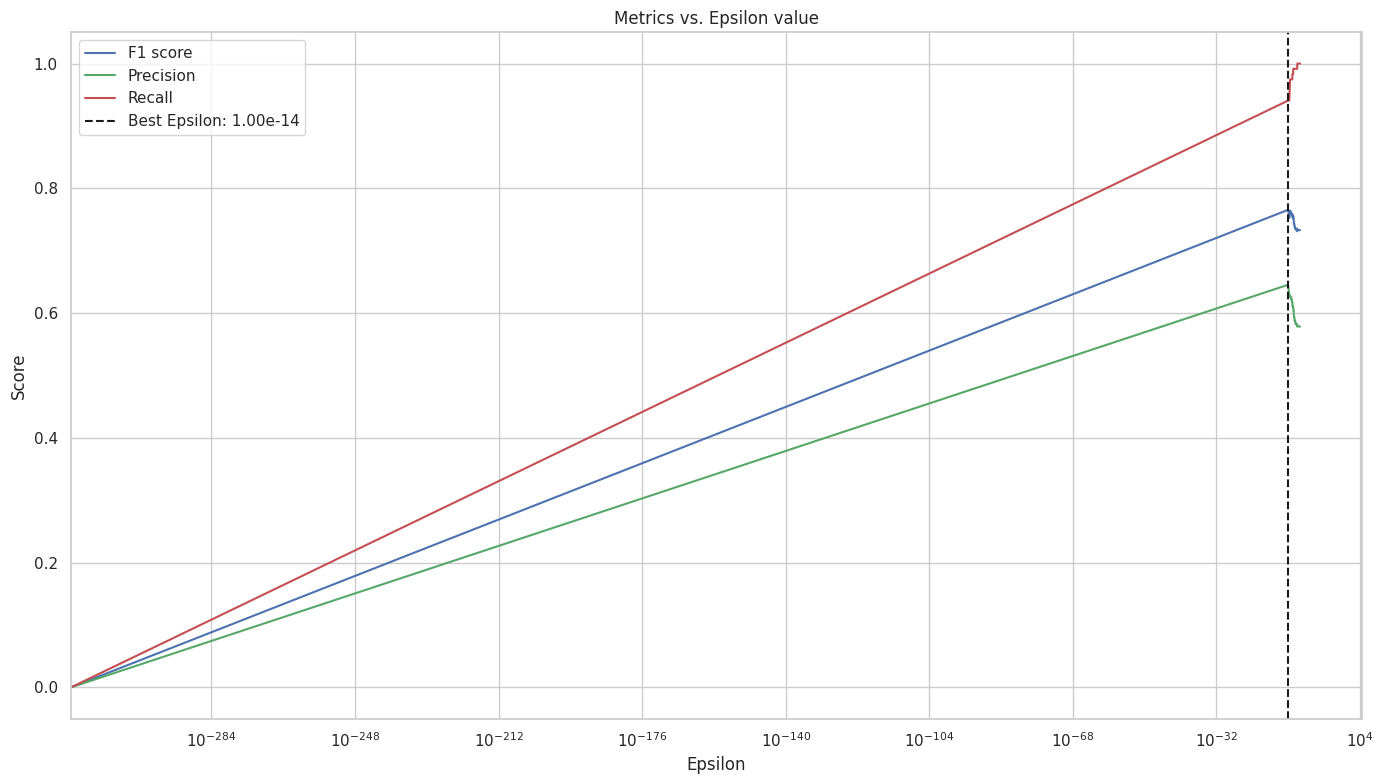

In [41]:
# Calculate mean vector
mu = np.mean(X_train, axis=0)

# Calculate covariance matrix
sigma = np.cov(X_train, rowvar=False)

print(f"Mean vector shape: {mu.shape}")
print(f"Covariance matrix shape: {sigma.shape}")


#Fine tuning the hyperparameter, the threshold ϵ

# Function to calculate multivariate Gaussian PDF
def multivariate_gaussian_pdf(X, mu, sigma):
    """Calculate the multivariate Gaussian probability density function"""
    n = mu.shape[0]

    # Handle potential numerical issues with the covariance matrix
    # Add a small regularization term to ensure positive definiteness
    sigma_reg = sigma + np.eye(n) * 1e-8

    # Calculate determinant and inverse
    try:
        det = np.linalg.det(sigma_reg)
        inv = np.linalg.inv(sigma_reg)
    except np.linalg.LinAlgError:
        # If still having issues, use pseudo-inverse
        print("Warning: Using pseudo-inverse for covariance matrix")
        det = max(np.linalg.det(sigma_reg), 1e-10)
        inv = np.linalg.pinv(sigma_reg)

    # Calculate PDF for each example
    p = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        x_mu = X[i] - mu
        p[i] = (1.0 / (np.power(2 * np.pi, n/2) * np.sqrt(det))) * \
               np.exp(-0.5 * x_mu.dot(inv).dot(x_mu))

    return p

# Compute the probability density function for the cross-validation set
p_cv = multivariate_gaussian_pdf(X_cross_val, mu, sigma)

# Find the range of epsilon values to search
min_epsilon = np.min(p_cv)
max_epsilon = np.max(p_cv)
step_size = (max_epsilon - min_epsilon) / 1000

# Find the best epsilon using F1 score
best_epsilon = 0
best_f1 = 0
best_precision = 0
best_recall = 0

epsilon_values = np.arange(min_epsilon, max_epsilon, step_size)
f1_scores = []
precisions = []
recalls = []

for epsilon in epsilon_values:
    predictions = (p_cv < epsilon).astype(int)

    # Calculate metrics
    precision = precision_score(y_cross_val, predictions, zero_division=0)
    recall = recall_score(y_cross_val, predictions, zero_division=0)

    # Calculate F1 score
    if precision + recall > 0:  # Avoid division by zero
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0

    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = epsilon
        best_precision = precision
        best_recall = recall

print(f"Best F1 score on CV set: {best_f1:.4f}")
print(f"Best Epsilon: {best_epsilon:.8e}")
print(f"Corresponding Precision: {best_precision:.4f}")
print(f"Corresponding Recall: {best_recall:.4f}")

# Plot F1 score, precision, and recall vs epsilon
plt.figure(figsize=(14, 8))
plt.plot(epsilon_values, f1_scores, 'b-', label='F1 score')
plt.plot(epsilon_values, precisions, 'g-', label='Precision')
plt.plot(epsilon_values, recalls, 'r-', label='Recall')
plt.axvline(x=best_epsilon, color='k', linestyle='--', label=f'Best Epsilon: {best_epsilon:.2e}')
plt.xlabel('Epsilon')
plt.ylabel('Score')
plt.title('Metrics vs. Epsilon value')
plt.legend()
plt.xscale('log')  # Log scale for better visualization
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation of results using precision, recall, F1 score and confusion matrix


Test set performance:
Precision: 0.6170
Recall: 0.9748
F1 Score: 0.7557

Confusion Matrix:
True Negatives: 16
False Positives: 72
False Negatives: 3
True Positives: 116


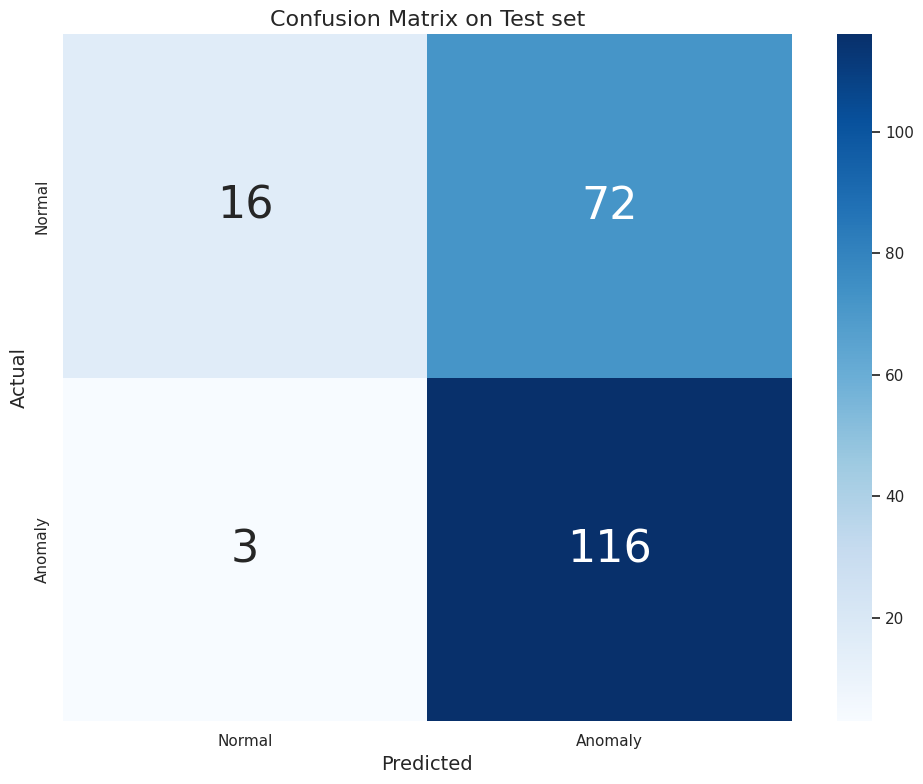

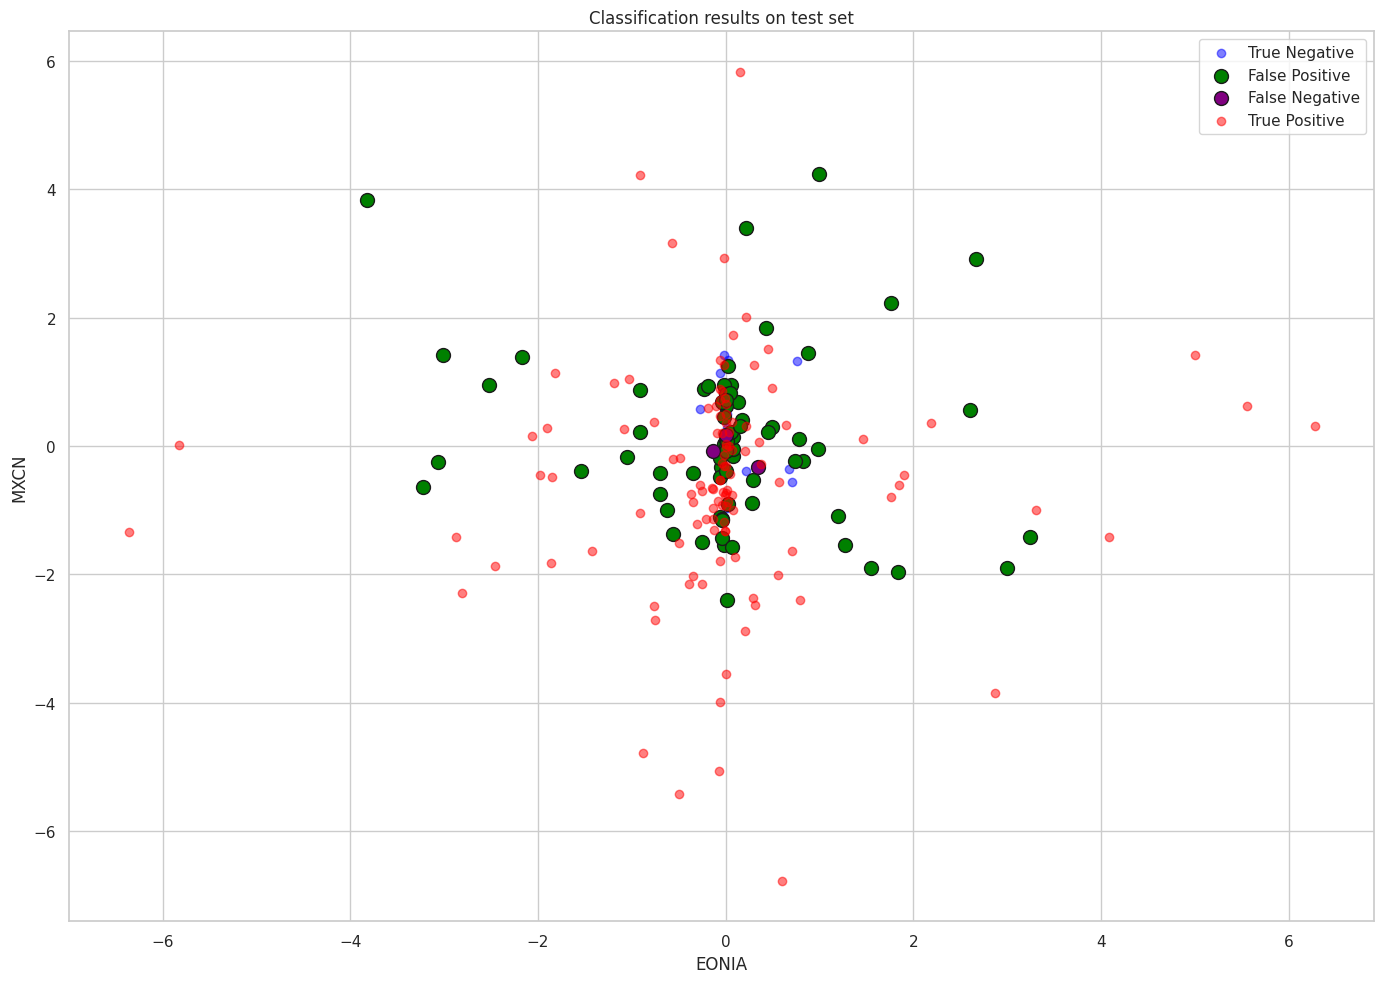

In [42]:
# Step 4: Testing the model

# Compute the probability density function for the test set
p_test = multivariate_gaussian_pdf(X_test, mu, sigma)

# Make predictions using the best epsilon
predictions = (p_test < best_epsilon).astype(int)

# Calculate metrics
MVG_precision = precision_score(y_test, predictions, zero_division=0)
MVG_recall = recall_score(y_test, predictions, zero_division=0)
MVG_f1 = f1_score(y_test, predictions, zero_division=0)

print("\nTest set performance:")
print(f"Precision: {MVG_precision:.4f}")
print(f"Recall: {MVG_recall:.4f}")
print(f"F1 Score: {MVG_f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 32})

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix on Test set', fontsize=16)
plt.tight_layout()
plt.show()



# Visualize examples of correctly and incorrectly classified points
# Select two features for visualization
if X_test.shape[1] >= 2:
    # Choose two features (columns) for visualization
    feature1_idx = 22  # First feature
    feature2_idx = 15  # Second feature

    # Get feature names
    feature1_name = stationary_df.columns[feature1_idx]
    feature2_name = stationary_df.columns[feature2_idx]

    plt.figure(figsize=(14, 10))

    # True negatives (correctly classified normal points)
    plt.scatter(X_test[(y_test == 0) & (predictions == 0), feature1_idx],
                X_test[(y_test == 0) & (predictions == 0), feature2_idx],
                c='blue', marker='o', alpha=0.5, label='True Negative')

    # False positives (normal points classified as anomalies)
    plt.scatter(X_test[(y_test == 0) & (predictions == 1), feature1_idx],
                X_test[(y_test == 0) & (predictions == 1), feature2_idx],
                c='green', marker='o', s=100, edgecolors='k', label='False Positive')

    # False negatives (anomalies classified as normal)
    plt.scatter(X_test[(y_test == 1) & (predictions == 0), feature1_idx],
                X_test[(y_test == 1) & (predictions == 0), feature2_idx],
                c='purple', marker='o', s=100, edgecolors='k', label='False Negative')

    # True positives (correctly classified anomalies)
    plt.scatter(X_test[(y_test == 1) & (predictions == 1), feature1_idx],
                X_test[(y_test == 1) & (predictions == 1), feature2_idx],
                c='red', marker='o', alpha=0.5, label='True Positive')

    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title('Classification results on test set')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    metrics_df = pd.DataFrame({
    'Precision': MVG_precision,
    'Recall': MVG_recall,
    'F1 Score': MVG_f1,
}, index=['MVG'])

### Visualization of MVG anomaly classification on PCA-reduced axis
PCA transformation on the test set to reduce the feature space to two dimensions for visual clarity.
It then plots each test observation according to:
- Prediction outcome: True Positive,
False Positive, etc.
- Anomaly direction: Anomaly Up, Anomaly Down, Normal

\\
We construct a composite market index based on market capitalization following this logic:
- Combine selected regional equity indices weighted by their global market share
- The weights reflect approximate market capitalization proportions
- A higher WEIGHTED_INDEX indicates stronger aggregate market performance
- Subtracting the scaled VIX (volatility index) captures risk-adjusted sentiment

Final composite_score = WEIGHTED_INDEX - VIX
- Higher values suggest strong, stable market conditions
- Lower values suggest elevated volatility or stress

In [43]:


# ----- Step 0: Prepare column index mapping for selected features
# Drop non-feature columns ('Y', 'Date') to extract usable market data columns
feature_columns = [col for col in stationary_df.columns if col not in ['Y', 'Date']]
# Create a dictionary that maps each feature name to its corresponding column index in X_test
column_to_index = {col: idx for idx, col in enumerate(feature_columns)}

# Construction of a Composite Market Index Based on Market Capitalization
# Market cap-based weights for key global indices
weights = {
    'MXUS': 0.45, 'MXEU': 0.20, 'MXCN': 0.10,
    'MXJP': 0.08, 'MXIN': 0.07, 'MXBR': 0.05, 'MXRU': 0.05
}

# Initialize the index to zero for each observation
weighted_index_scaled = np.zeros(X_test.shape[0])

# Multiply each selected index by its weight and sum across columns
for col, weight in weights.items():
    if col in column_to_index:
        weighted_index_scaled += X_test[:, column_to_index[col]] * weight

# Extract the scaled VIX values from the appropriate column
vix_scaled = X_test[:, column_to_index['VIX']]

# Final composite score: market strength adjusted for volatility
composite_score = weighted_index_scaled - vix_scaled

# Determine median value to split positive and negative market signals
threshold = np.percentile(composite_score, 50)

# Assign market condition labels based on composite score
market_condition = []
for i, score in enumerate(composite_score):
    if y_test[i] == 1:
        # Only apply Up/Down classification to actual anomalies
        market_condition.append('Anomaly Up' if score > threshold else 'Anomaly Down')
    else:
        market_condition.append('Normal')  # For normal market observations

# --- Step 1: Perform PCA transformation on the test set for visualization ---
# Reduce dimensionality to 2D to plot and analyze the structure of model predictions
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)  # Use X_test_scaled here if the model used scaled features

# --- Step 2: Set up visual styles for plotting each prediction category ---

plt.figure(figsize=(14, 10))

# Marker size reflects classification type: larger for positive predictions
size_map = {
    'True Positive': 60,
    'False Positive': 100,
    'False Negative': 100,
    'True Negative': 60
}

# Color uniquely identifies each (prediction type, market condition) combination
color_map = {
    ('True Positive', 'Anomaly Up'): 'darkgreen',
    ('True Positive', 'Anomaly Down'): 'salmon',
    ('True Positive', 'Normal'): 'lime',

    ('False Positive', 'Anomaly Up'): 'orange',
    ('False Positive', 'Anomaly Down'): 'red',
    ('False Positive', 'Normal'): 'gold',

    ('False Negative', 'Anomaly Up'): 'teal',
    ('False Negative', 'Anomaly Down'): 'purple',
    ('False Negative', 'Normal'): 'pink',

    ('True Negative', 'Anomaly Up'): 'gray',  # Rare cases where Normal is misclassified as Up
    ('True Negative', 'Anomaly Down'): 'gray',
    ('True Negative', 'Normal'): 'gray'
}

# Helper function to scatter-plot each group with its style and label
def plot_group(mask, base_label, condition):
    count = np.sum(mask)  # Count number of samples in this group
    if count > 0:
        label = f"{base_label} ({condition}) ({count})"
        plt.scatter(X_test_pca[mask, 0],  # Principal Component 1
                    X_test_pca[mask, 1],  # Principal Component 2
                    label=label,
                    c=color_map[(base_label, condition)],
                    s=size_map[base_label],
                    alpha=0.7,
                    edgecolors='k')

# --- Step 3: Plot all prediction groups categorized by market condition

# Iterate over all possible true/predicted combinations
for actual, predicted, base_label in [(0, 0, 'True Negative'),
                                      (0, 1, 'False Positive'),
                                      (1, 0, 'False Negative'),
                                      (1, 1, 'True Positive')]:
    # Further subdivide by market anomaly condition
    for condition in ['Anomaly Up', 'Anomaly Down', 'Normal']:
        mask = (y_test == actual) & (predictions == predicted) & (np.array(market_condition) == condition)
        plot_group(mask, base_label, condition)

# --- Step 4: Final plot formatting

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MVG Classification with Anomaly Direction on PCA Axes")
plt.legend(fontsize=10, loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In the graph above, each (outcome, condition) pair is represented with a unique color, and point size varies by prediction type to highlight detection performance.
The legend includes the number of observations for each group.

## Non linear projection with UMAP
UMAP is a nonlinear dimensionality reduction technique that captures manifold structure in the data, we use it to deal with non linearity

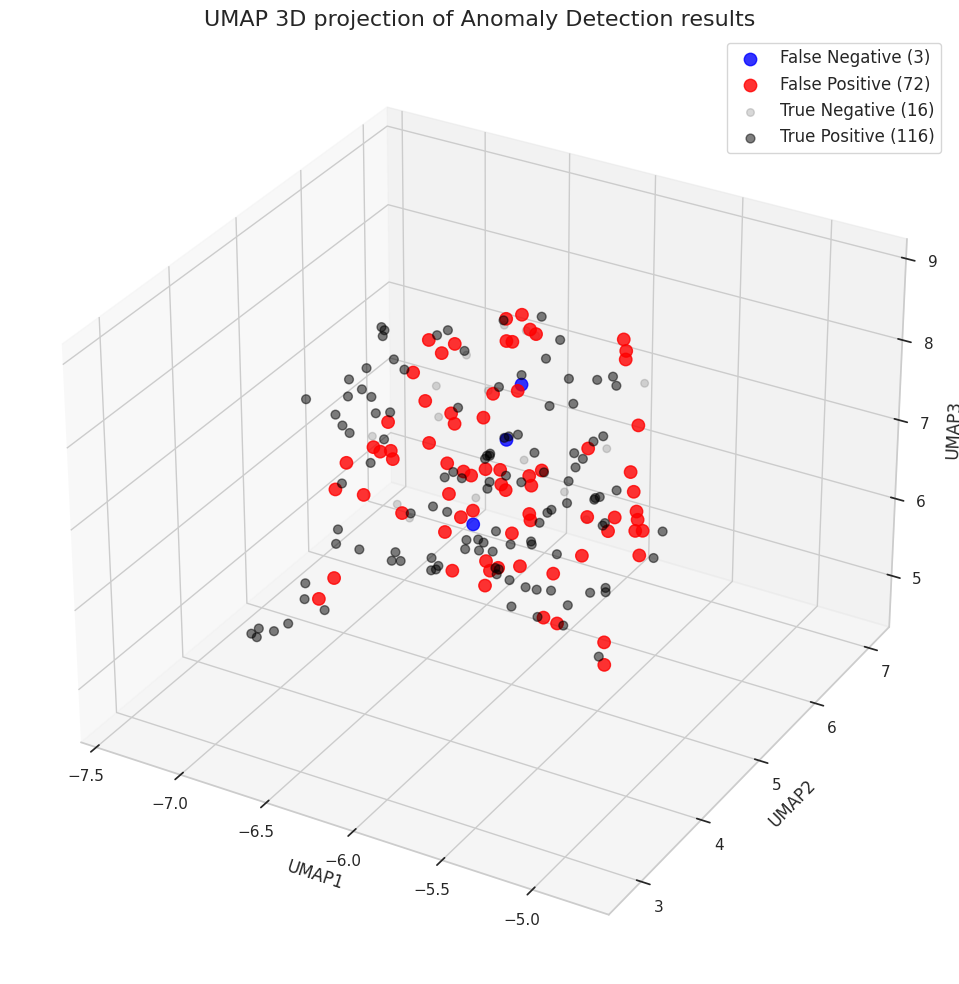

In [44]:
# UMAP visualization of anomalies in 3D

# Apply UMAP to reduce dimensionality to 3 components
umap_3d = umap.UMAP(n_components=3, random_state=42)
X_test_umap = umap_3d.fit_transform(X_test)

# Create a DataFrame for easier plotting
umap_df = pd.DataFrame(X_test_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['Actual'] = y_test
umap_df['Predicted'] = predictions

# Create classification categories
umap_df['Category'] = 'Unknown'
umap_df.loc[(y_test == 0) & (predictions == 0), 'Category'] = 'True Negative'
umap_df.loc[(y_test == 0) & (predictions == 1), 'Category'] = 'False Positive'
umap_df.loc[(y_test == 1) & (predictions == 0), 'Category'] = 'False Negative'
umap_df.loc[(y_test == 1) & (predictions == 1), 'Category'] = 'True Positive'

# Define colors, markers, alphas, and sizes
colors = {'True Negative': 'gray', 'True Positive': 'black',
          'False Positive': 'red', 'False Negative': 'blue'}
alphas = {'True Negative': 0.3, 'True Positive': 0.5,
          'False Positive': 0.8, 'False Negative': 0.8}
sizes = {'True Negative': 30, 'True Positive': 40,
         'False Positive': 80, 'False Negative': 80}

# Plot the UMAP 3D projection
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each category
for category, group in umap_df.groupby('Category'):
    ax.scatter(group['UMAP1'], group['UMAP2'], group['UMAP3'],
               color=colors[category],
               alpha=alphas[category],
               s=sizes[category],
               label=f"{category} ({len(group)})")

# Title and labels
ax.set_title('UMAP 3D projection of Anomaly Detection results', fontsize=16)
ax.set_xlabel('UMAP1', fontsize=12)
ax.set_ylabel('UMAP2', fontsize=12)
ax.set_zlabel('UMAP3', fontsize=12)

# Legend and layout
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()


## SUPERVISED MODELS
Models trained using the anomalis lables we have

We permormed:
- Random Forest with tuned threshold
- Random Forest tuned with Optuna

Functions and utilities for comparison of supervised and unsupervised Anomaly Detection methods

In [45]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# We already have X_train, X_cross_val, y_cross_val, X_test, y_test from previous code cells
# We'll standardize the data for better performance with many algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cross_val)
X_test_scaled = scaler.transform(X_test)
X_train_cv = np.vstack((X_train_scaled, X_cv_scaled))
y_train_cv = np.hstack((np.zeros(len(X_train_scaled)), y_cross_val))

# Function to evaluate and visualize model performance
def evaluate_model(y_true, y_pred, y_score, model_name):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n{model_name} Performance:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 32})

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    if y_score is not None:  # Some models don't provide probability scores
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    return precision, recall, f1

# Function to visualize results in PCA space
def visualize_pca(X, y_true, y_pred, model_name):
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Actual'] = y_true
    pca_df['Predicted'] = y_pred

    # Create classification categories
    pca_df['Category'] = 'Unknown'
    pca_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    pca_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    pca_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    pca_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    total_variance = sum(explained_variance)

    # Plot
    plt.figure(figsize=(12, 8))

    # Define colors and sizes
    colors = {'True Negative': 'gray', 'True Positive': 'black',
              'False Positive': 'red', 'False Negative': 'blue'}
    alphas = {'True Negative': 0.3, 'True Positive': 0.5,
              'False Positive': 0.8, 'False Negative': 0.8}
    sizes = {'True Negative': 30, 'True Positive': 40,
             'False Positive': 80, 'False Negative': 80}

    # Plot each category
    for category, group in pca_df.groupby('Category'):
        plt.scatter(group['PC1'], group['PC2'],
                    color=colors[category],
                    alpha=alphas[category],
                    s=sizes[category],
                    label=f"{category} ({len(group)})")

    plt.title(f'PCA projection - {model_name}\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Store results for comparison
results = []

## Random Forest with tuned threshold
As threshold of the Random Forest, we choose the one that maximazes the F1-score




Random Forest (Supervised, tuned threshold) Performance:
Precision: 0.7551
Recall: 0.9328
F1 Score: 0.8346


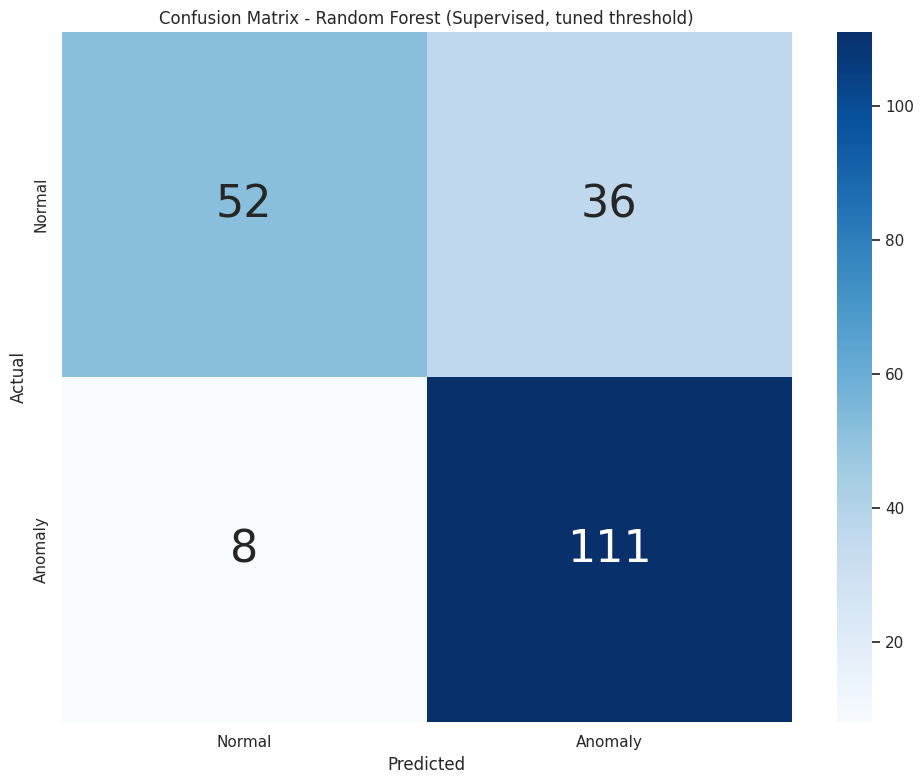

In [46]:
# Training and cross-validation combination
X_train_cv = np.vstack((X_train_scaled, X_cv_scaled))
y_train_cv = np.hstack((np.zeros(len(X_train_scaled)), y_cross_val))

# Model training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_cv, y_train_cv)

# Prevision of probabilities on the test set
rf_scores = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilità di essere anomalia

# Threshold tuning to optimize the F1-score
precisions, recalls, thresholds = precision_recall_curve(y_test, rf_scores)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

# Optimal threshold application
rf_pred = (rf_scores >= best_threshold).astype(int)

# Model valuation
rf_metrics = evaluate_model(y_test, rf_pred, rf_scores, "Random Forest (Supervised, tuned threshold)")
#print(best_threshold)

# Save results
results.append(("Random Forest tuned threshold)", *rf_metrics))

metrics_df.loc['Random Forest tuned threshold'] = {'Precision': rf_metrics[0],
                                                  'Recall': rf_metrics[1],
                                                  'F1 Score': rf_metrics[2]}


## Random Forest tuned with Optuna
Advanced tuning of Random Forest model with Optuna.

Optuna is an automatic hyperparameter optimization framework. It searches for the best combination of hyperparameters to improve a model's performance.
It works by:

- Defining an objective function that evaluates model performance (MCC-Matthews Correlation Coefficient)

- Using intelligent sampling algorithms to explore the hyperparameter space efficiently.

- Maximizing the objective function over multiple trials.

The threshold is still chosen as the one that maximizes the F1-score.

[I 2025-06-24 09:44:16,524] A new study created in memory with name: no-name-ee0e1ff3-c35c-4b79-97ef-b3d4b03f9711


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-24 09:44:57,194] Trial 0 finished with value: 0.5553957425326501 and parameters: {'n_estimators': 961, 'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.5553957425326501.
[I 2025-06-24 09:45:19,661] Trial 1 finished with value: 0.5433171947915867 and parameters: {'n_estimators': 445, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': None}. Best is trial 0 with value: 0.5553957425326501.
[I 2025-06-24 09:45:27,113] Trial 2 finished with value: 0.425476610312567 and parameters: {'n_estimators': 383, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5553957425326501.
[I 2025-06-24 09:45:47,862] Trial 3 finished with value: 0.5416572471940138 and parameters: {'n_estimators': 430, 'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 4, 

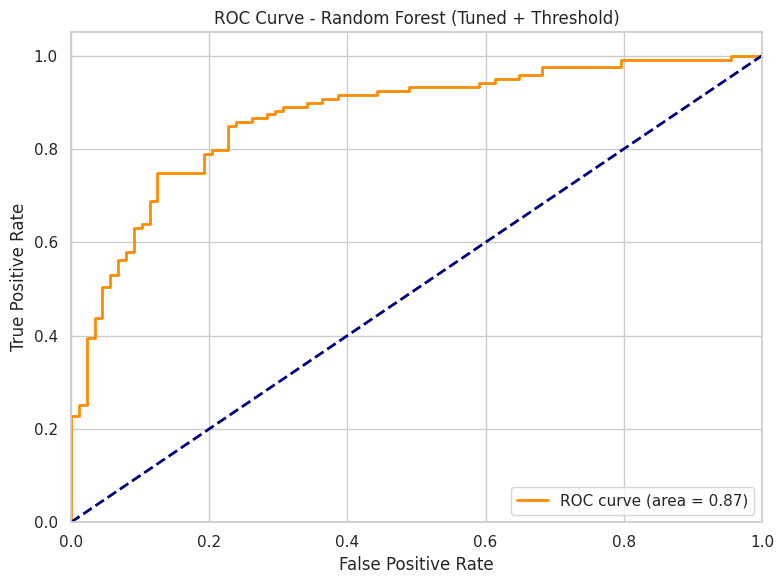

Matthews Correlation Coefficient: 0.6227


In [47]:
# ----------------------------
# Optuna tuning (sulla MCC)
# ----------------------------
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.7, None])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(rf, X_train_cv, y_train_cv,
                            cv=5, scoring=make_scorer(matthews_corrcoef), n_jobs=-1)
    return score.mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

print("Migliori parametri RF:", study_rf.best_params)

# ----------------------------
# Final train optimal parameters
# ----------------------------
best_rf = RandomForestClassifier(
    **study_rf.best_params,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train_cv, y_train_cv)

# ----------------------------
# Predict proba e tuning treshold
# ----------------------------
rf_scores = best_rf.predict_proba(X_test_scaled)[:, 1]  # Probabilità di classe 1

precisions, recalls, thresholds = precision_recall_curve(y_test, rf_scores)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Soglia ottimale F1-score: {best_threshold:.4f}")

# Predizione finale con soglia ottimale
rf_pred = (rf_scores >= best_threshold).astype(int)

# ----------------------------
# Evaluation
# ----------------------------
rf_metrics = evaluate_model(y_test, rf_pred, rf_scores, "Random Forest (Tuned + Threshold)")
results.append(("Random Forest (Tuned Threshold + Parameters)", *rf_metrics))

metrics_df.loc['Random Forest (Tuned Threshold + Parameters)'] = {
    'Precision': rf_metrics[0],
    'Recall': rf_metrics[1],
    'F1 Score': rf_metrics[2]
}

mcc = matthews_corrcoef(y_test, rf_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


# Elliptic Envelope
This method tries to fit a Guassian distribution to data computing the sample mean and the sample covariance matrix. Given the expected rate of outliers as input (*anomaly rate*), it returns the ellipsoid centered in the mean than collects (1-*anomaly rate*)% of the original data. The threshold is computed using the Mahalanobis distance, whose distribution under normality assumption is given by a Chi-squared with **p** degrees of freedom, where **p** is the dimensionality of the embedding space.

In [48]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

print(f"Training set size: {X_train.shape[0]} (all normal)")
print(f"Cross-validation set size: {X_cross_val.shape[0]} ({cv_normal_size} normal, {cv_anomaly_size} anomalies)")
print(f"Test set size: {X_test.shape[0]} ({len(X_test_normal)} normal, {len(X_test_anomaly)} anomalies)")
print("Test shape", X_test.shape)
print("y object", type(y))

Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)
Test shape (207, 42)
y object <class 'numpy.ndarray'>


## Function definition

Before applying the elliptic algortihm, we define some functions that we will apply in the next sections

Function implementation:

Given a sample $X_1, \ldots, X_n \overset{\text{iid}}{\sim} \mathcal{N}(\mu, \Sigma)$, with $\mu \in \mathbb{R}^p$ and $\Sigma \in \mathbb{R}^{p \times p}$, the Mahalanobis distance of a point $x$ from the mean $\mu$ is induced by the covariance matrix $\Sigma$, is defined as:
$d^2(x, \mu) = (x - \mu)' \Sigma^{-1} (x - \mu)$

Unlike the Euclidean distance, the Mahalanobis distance takes into account the covariance structure that generates the data.




In [49]:
# Differently from the Euclidean distance, the Mahalanobis distance takes into account the covariance
# structure that generates data.
def mahalanobis_distance(X_df):
    """
    Computes the Mahalanobis distance of each unit of the dataset passed as input

    Args:
        X_df (DataFrame): dataset

    Returns:
        numpy array: Mahalanobis distance vector
    """
    """
    Ritorna un Numpy Array
    """
    X_df_centered = X_df - np.mean(X_df, axis=0)
    cov = np.cov(X_df, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    mahal_dist = []
    for i in range(X_df.shape[0]):
        mahal_dist.append(np.sqrt(X_df_centered[i].dot(inv_cov).dot(X_df_centered[i])))
    return np.array(mahal_dist)


def print_evaluation(y, y_pred, title):
    """
    Auxiliary function that plots the confusion matrix of a classifier. It
    also returns some evaluation metrics.

    Args:
       y: true labels.
       y: predicted labels.
    """
    print(f"\n{title}:")
    cm = confusion_matrix(y, y_pred)
    print("Matrice di confusione:")
    print(cm)

    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) # Ratio of correct predictions
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0 # Correct positive predictions over the total positive ones
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0 # Percentage of positive values identified
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0 # F-score

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y, y_pred))

## Gaussianity check
**Univariate case**

Even if Shapiro-Wilk test is widely used in statistics, it has some criticalities:


*   it can be applied if the sample size n is between 3 and 5000
*   it is very sensitive to deviation from normality

That's why, we will compare it with the results given by Jera-Barque test, which is more suited to financial series since it takes into account both kurtosis and skewness.

**Multivariate case**

To check if gaussianity is satisfied, we will compare the Malahanobis distance of the points in our dataset with the theoretical quantiles of a Chi-squared distribution

In [50]:
warnings.filterwarnings('ignore')

# Convert 'X_test' and 'y_test' to DataFrame type
X_test_df = pd.DataFrame(X_test, columns=X_df.columns)
y = pd.DataFrame(y_test, columns=['Y_Flag'])

# Create a DataFrame in which we save the test results
print("\n--- Univariate Gaussianity Test ---\n")
shapiro_results = pd.DataFrame(columns=['Indice', 'Statistics', 'P-value', 'Normal'])
bj_results = pd.DataFrame(columns=['Indice', 'Statistics', 'P-value', 'Normal'])

for col in X_test_df.columns:  # Iterate over the indeces (i.e over the columns of the dataset)
    # Shapiro - Wilk Test
    stat, p = stats.shapiro(X_test_df[col])
    shapiro_results.loc[len(shapiro_results)] = [col, stat, p, p > 0.05]  # Save the result in the first line available
    # Bera - Jarque Test
    stat, p = stats.jarque_bera(X_test_df[col])
    bj_results.loc[len(bj_results)] = [col, stat, p, p > 0.05]

# Print results
print(
    f"\nIndices with a gaussian distribution [S-W]: {shapiro_results['Normal'].sum()} su {len(shapiro_results)}")
print(f"\nIndices with a gaussian distribution [B-J]: {bj_results['Normal'].sum()} su {len(bj_results)}")
normality_results = pd.concat([shapiro_results, bj_results], axis=0)
normality_results.to_excel("Normality_results.xlsx", index=True)

# 2.3 Test di normalità multivariata
print("\n--- Multivariate Gaussianity Test ---\n")

# Standardizziamo i dati prima di calcolare la distanza di Mahalanobis
# X_df_std = StandardScaler().fit_transform(X_df) # I dati sono già standardizzati
mahal_dist = mahalanobis_distance(X_test_df.values)

# Recall that in gaussian framework, the square of the Mahalanobis distance is a Chi-squared with p degrees of freedom
chi2_quantiles = stats.chi2.ppf(np.arange(0.01, 1, 0.01), df=X_test_df.shape[1])
mahal_dist_sorted = np.sort(mahal_dist ** 2)

plt.figure(figsize=(10, 6))
plt.scatter(chi2_quantiles, mahal_dist_sorted[:len(chi2_quantiles)], alpha=0.6)
plt.plot([0, max(chi2_quantiles)], [0, max(chi2_quantiles)], 'r--')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.title('QQ-Plot to assess multivariate gaussianity')
plt.grid(True)
plt.tight_layout()
plt.close()

print(
    "If the points deviate significantly from the red line, the data do not follow a multivariate normal distribution")



--- Univariate Gaussianity Test ---


Indices with a gaussian distribution [S-W]: 2 su 42

Indices with a gaussian distribution [B-J]: 2 su 42

--- Multivariate Gaussianity Test ---

If the points deviate significantly from the red line, the data do not follow a multivariate normal distribution


From the plot it is clearly visible that the data are not gaussian at all since points are located way below the theoretical line.

To tackle this issue, we try to apply **PowerTransformer** to make data more gaussian-like. In particular, we resort to the *Yeo-Johnson* method which is able to deal with both positive and negative data.

In [51]:
print("\n--- TRASFORMATIONS ---\n")
print("Applying PowerTransformer...\n")

# Apply PowerTransformer al dataset X_test_df
pt = PowerTransformer(method='yeo-johnson')
X_test_tran = pt.fit_transform(X_test_df)

# Convert X_test_tran from ndarray to Dataframe
X_test_tran_df = pd.DataFrame(X_test_tran, columns=X_test_df.columns, index=X_test_df.index)


--- TRASFORMATIONS ---

Applying PowerTransformer...



In [52]:
# Let's repeat the gaussianity tests again

print("\n--- Univariate Gaussianity Test ---\n")
# Clean dataframes containing the results about S-W and B-J tests we did before
#print("Shapiro pre pulizia:", shapiro_results.shape)
shapiro_results = pd.DataFrame(columns = shapiro_results.columns)
bj_results = pd.DataFrame(columns = bj_results.columns)
#print("Shapiro post pulizia:", shapiro_results.shape)

for col in X_test_tran_df.columns: # Iterate over the indeces (i.e over the columns of the dataset)
    # Shapiro - Wilk Test
    stat, p = stats.shapiro(X_test_tran_df[col])
    shapiro_results.loc[len(shapiro_results)] = [col, stat, p, p > 0.05]  # Save the result into the first available line
    # Bera - Jarque Test
    stat, p = stats.jarque_bera(X_test_tran_df[col])
    bj_results.loc[len(bj_results)] = [col, stat, p, p > 0.05]

# Print results
print(f"\nIndices with a gaussian distribution [S-W]: {shapiro_results['Normal'].sum()} su {len(shapiro_results)}")
print(f"\nIndices with a gaussian distribution [B-J]: {bj_results['Normal'].sum()} su {len(bj_results)}")

normality_results = pd.concat([shapiro_results, bj_results], axis=0)
normality_results.to_excel("Normality_results_post.xlsx", index = True)

# 2.3 Test di normalità multivariata (approssimazione semplificata)
print("\n--- MULTIVARIATE NORMALITY TEST ---\n")

# Standardizziamo i dati prima di calcolare la distanza di Mahalanobis
#X_test_tran_df_std = StandardScaler().fit_transform(X_test_tran_df)
mahal_dist = mahalanobis_distance(X_test_tran_df.values)

# Recall that in gaussian framework, the square of the Mahalanobis distance is a Chi-squared with p degrees of freedom
chi2_quantiles = stats.chi2.ppf(np.arange(0.01, 1, 0.01), df=X_test_tran_df.shape[1])
mahal_dist_sorted = np.sort(mahal_dist**2)

plt.figure(figsize=(10, 6))
plt.scatter(chi2_quantiles, mahal_dist_sorted[:len(chi2_quantiles)], alpha=0.6)
plt.plot([0, max(chi2_quantiles)], [0, max(chi2_quantiles)], 'r--')
plt.xlabel('Theoretical Chi-squared quantiles')
plt.ylabel('Empirical quantiles of the Mahalanobis squared distances')
plt.title('QQ-Plot for assessing multivariate normality')
plt.grid(True)
plt.tight_layout()
plt.close()



--- Univariate Gaussianity Test ---


Indices with a gaussian distribution [S-W]: 2 su 42

Indices with a gaussian distribution [B-J]: 3 su 42

--- MULTIVARIATE NORMALITY TEST ---



It is visible that the transformation is not enough to recover the normality assumption. This is probabibly due to the high-dimensionality of the embedding space.

Well aware of this problem, we try to apply the Elliptic envelope anyway. Given that the test set contains more than 50% of anomalies, we pass 0.5 as input in the Elliptic Envelope initialization (max. value allowed).


--- ELLIPTIC ENVELOPE ---

Percentage of anomalies in the test set: 0.5749 (119 su 207)

--- RESULT VALUATION ---


StandardScaler valuation:
Matrice di confusione:
[[58 30]
 [46 73]]
Accuracy: 0.6329
Precision: 0.7087
Recall: 0.6134
F1-score: 0.6577

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.66      0.60        88
           1       0.71      0.61      0.66       119

    accuracy                           0.63       207
   macro avg       0.63      0.64      0.63       207
weighted avg       0.64      0.63      0.63       207


--- RESULTS VALUATION ---

Comparison graph saves as 'anomalies_comparison.png'

False positives: 30 observations
False negatives: 46 observations


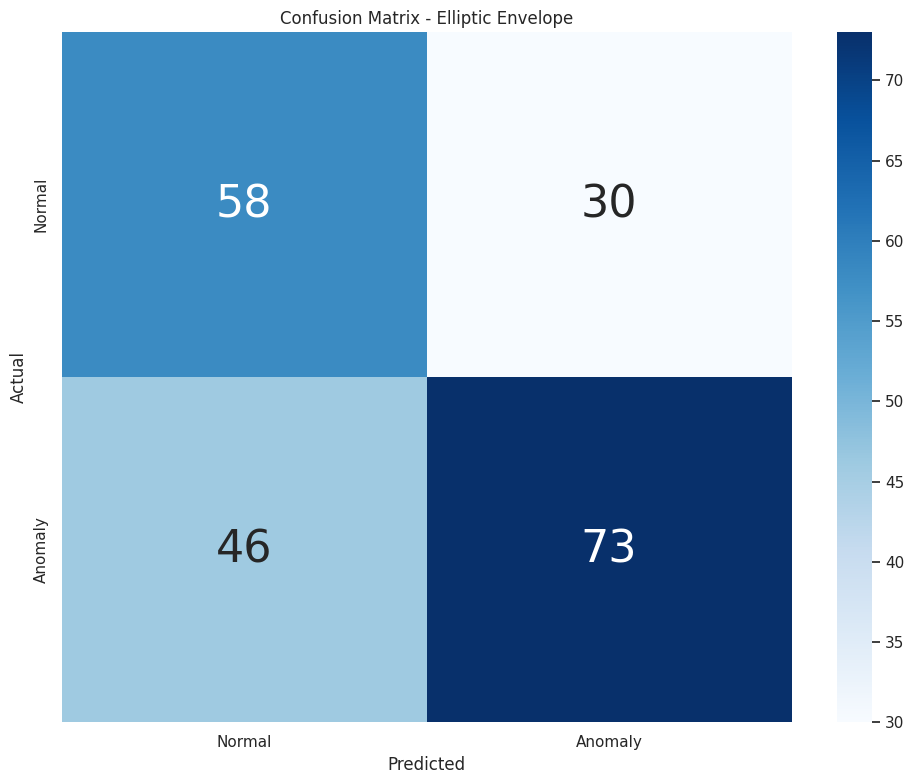

In [53]:
print("\n--- ELLIPTIC ENVELOPE ---\n")

# Compute the anomaly rate of our test set
anomaly_rate = y.mean().iloc[0]
print(f"Percentage of anomalies in the test set: {anomaly_rate:.4f} ({int(anomaly_rate*len(X_test_df))} su {len(X_test_df)})")
#
# Set the contamination parameter according to the percentage of existing anomalies
contamination = anomaly_rate

# Elliptic Envelope application with StandardScaler
envelope_std = EllipticEnvelope(contamination=0.5, random_state=42)
y_pred_std = envelope_std.fit_predict(X_test_tran_df)
# Convert to binary format (1 for inlier, -1 for outlier → 0 for normal, 1 for anomaly)
y_pred_std_binary = np.where(y_pred_std == -1, 1, 0)

# The decision_function() method of the EllipticEnvelope object returns a measure of the distance
# of each point from the center of the elliptical distribution. The more negative the value, the more likely it is to be an outlier.
# By prepending a minus sign, we obtain that: higher values indicate a higher likelihood of being an anomaly.

anomaly_scores_std = -envelope_std.decision_function(X_test_tran_df)

# 5. Evaluation and comparison with the original labels
print("\n--- RESULT VALUATION ---\n")

# Convert y to binary numeric format if necessary
y_binary = y.astype(int)

# DataFrame
results = pd.DataFrame({
    'True_Anomaly': y_binary.values.ravel(),
    'Predicted_Std': y_pred_std_binary,
    'Score_Std': anomaly_scores_std,
})

# Calculate the evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report
print_evaluation(y_binary, y_pred_std_binary, "StandardScaler valuation")

metrics_df.loc['Elliptic Envelope (StandardScaler)'] = {
    'Precision': precision_score(y_binary, y_pred_std_binary, zero_division=0),
    'Recall': recall_score(y_binary, y_pred_std_binary, zero_division=0),
    'F1 Score': f1_score(y_binary, y_pred_std_binary, zero_division=0)
}

# Results
print("\n--- RESULTS VALUATION ---\n")

mahalanobis_envelope = envelope_std.mahalanobis(X_test_tran_df)
# Threshold
threshold = np.percentile(mahalanobis_envelope, 100 * (1 - envelope_std.contamination))

# 6.1 Comparison between true and predicted anomalies
plt.figure(figsize=(10, 6))
plt.scatter(range(len(results)), results['Score_Std'], c=results['True_Anomaly'],
           alpha=0.6, edgecolor='k', s=50, cmap='coolwarm')

plt.axhline(y=threshold, color='r', linestyle='--',
           label=f'Decision threshold: {threshold:.4f}')

plt.xlabel('Observation index')
plt.ylabel('Anomaly score (StandardScaler)')
plt.title('Comparison between true anomalies and anomaly scores')
plt.colorbar(label='True anomaly (1=Yes, 0=No)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('anomalies_comaprison.png')
plt.close()

print("Comparison graph saves as 'anomalies_comparison.png'")

# 6.2 Error analysis
# Identify false positives and false negatives
y_binary_array = y_binary.values.flatten()
y_pred_array = y_pred_std_binary.flatten()
fp_indices = np.where((y_binary_array == 0) & (y_pred_array == 1))[0]
fn_indices = np.where((y_binary_array == 1) & (y_pred_array == 0))[0]

print(f"\nFalse positives: {len(fp_indices)} observations")
print(f"False negatives: {len(fn_indices)} observations")

# Confusion Matrix
cm = confusion_matrix(y_binary_array, y_pred_std_binary)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 32})  # Increase the font size here
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Elliptic Envelope')
plt.tight_layout()
plt.show()

In [54]:
def plot_pca_results(X_data, y_true, y_pred, title='PCA with errors classification'):
    """
    Visualize the observations in the plane of the first two principal components,
    highlighting TP, TN, FP, and FN with different colors.

    Parameters:
    X_data (DataFrame or ndarray): Input data
    y_true (array): True labels (1 for anomaly, 0 for normal)
    y_pred (array): Predicted labels (1 for anomaly, 0 for normal)
    title (str): Title of the plot

    Returns:
    None: Saves the plot as 'pca_classification_results.png'
    """

    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import numpy as np

    X = np.array(X_data)
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # PCA for 2 dimensions reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

  # Create error categories
  # TP: True anomalies correctly identified (y_true=1, y_pred=1)
  # TN: Normals correctly identified (y_true=0, y_pred=0)
  # FP: Normals incorrectly identified as anomalies (y_true=0, y_pred=1)
  # FN: Anomalies incorrectly identified as normal (y_true=1, y_pred=0)

    tp_indices = np.where((y_true == 1) & (y_pred == 1))[0]
    tn_indices = np.where((y_true == 0) & (y_pred == 0))[0]
    fp_indices = np.where((y_true == 0) & (y_pred == 1))[0]
    fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]

    colors = {
        'TP': '#2ca02c',  # Green
        'TN': '#1f77b4',  # Blue
        'FP': '#ff7f0e',  # Orange
        'FN': '#d62728'   # Red
    }

    plt.figure(figsize=(12, 8))

    # Add information for each category
    plt.scatter(X_pca[tn_indices, 0], X_pca[tn_indices, 1], c=colors['TN'],
                label=f'TN (True negatives): {len(tn_indices)}', alpha=0.7, s=50, edgecolor='k')
    plt.scatter(X_pca[tp_indices, 0], X_pca[tp_indices, 1], c=colors['TP'],
                label=f'TP (True positives): {len(tp_indices)}', alpha=0.7, s=50, edgecolor='k')
    plt.scatter(X_pca[fp_indices, 0], X_pca[fp_indices, 1], c=colors['FP'],
                label=f'FP (False positives): {len(fp_indices)}', alpha=0.7, s=50, edgecolor='k')
    plt.scatter(X_pca[fn_indices, 0], X_pca[fn_indices, 1], c=colors['FN'],
                label=f'FN (False negatives): {len(fn_indices)}', alpha=0.7, s=50, edgecolor='k')

    # Aggiungi informazioni sul grafico
    plt.title(title, fontsize=14)
    plt.xlabel(f'First principal component ({pca.explained_variance_ratio_[0]:.2%} variance explained)', fontsize=12)
    plt.ylabel(f'Second principal component ({pca.explained_variance_ratio_[1]:.2%} variance explained)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10, loc='best')

    # Aggiungi annotazioni sulle performance
    accuracy = (len(tp_indices) + len(tn_indices)) / len(y_true)
    precision = len(tp_indices) / (len(tp_indices) + len(fp_indices)) if (len(tp_indices) + len(fp_indices)) > 0 else 0
    recall = len(tp_indices) / (len(tp_indices) + len(fn_indices)) if (len(tp_indices) + len(fn_indices)) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    plt.figtext(0.02, 0.02, f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Salva il grafico
    plt.tight_layout()
    plt.close()
    plt.show()


    # Ritorni anche le varianze spiegate
    return pca.explained_variance_ratio_

plot_pca_results(X_test_tran_df, y_binary, y_pred_std_binary,
                'EllipticEnvelope classification in the PCA plane')

array([0.23238173, 0.18397023])

## Autoencoder







In [55]:
# 3.  Deep Learning methods: Autoencoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_cv_tensor = torch.FloatTensor(X_cv_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # Input = Output for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(Autoencoder, self).__init__()
                # Calculate layer sizes for a gradually decreasing architecture
        layer1_size = int(input_dim * (3/4))
        layer2_size = int(layer1_size * (3/4))
        layer3_size = int(layer2_size * (3/4))
        layer4_size = int(layer3_size * (3/4))


        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Linear(layer1_size, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Linear(layer2_size, layer3_size),
            nn.BatchNorm1d(layer3_size),
            nn.ReLU(True),
            nn.Linear(layer3_size, layer4_size),
            nn.BatchNorm1d(layer4_size),
            nn.ReLU(True),
            nn.Linear(layer4_size, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU(True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, layer4_size),
            nn.BatchNorm1d(layer4_size),
            nn.ReLU(True),
            nn.Linear(layer4_size, layer3_size),
            nn.BatchNorm1d(layer3_size),
            nn.ReLU(True),
            nn.Linear(layer3_size, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Linear(layer2_size, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Linear(layer1_size, input_dim),
            nn.Tanh()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

# Get input dimension from data
input_dim = X_train_scaled.shape[1]
print(f"Input dimension: {input_dim}")

# Create the autoencoder model
encoding_dim = min(16, input_dim // 4)
autoencoder_model = Autoencoder(input_dim, encoding_dim).to(device)
print(f"Encoding dimension: {encoding_dim}")
print(autoencoder_model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.001, weight_decay=1e-5)

# Training function
def train_autoencoder(model, train_loader, num_epochs=500, patience=20):
    # For early stopping
    best_loss = float('inf')
    no_improve_epochs = 0

    # For plotting
    train_losses = []

    print("Training autoencoder...")
    for epoch in range(num_epochs):
        autoencoder_model.train()
        running_loss = 0.0

        for data, _ in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = autoencoder_model(data)
            loss = criterion(outputs, data)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)

        # Calculate epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}')
        if epoch_loss < best_loss:
         best_loss = epoch_loss
         no_improve_epochs = 0
         torch.save(model.state_dict(), 'best_autoencoder.pth')
        else:
         no_improve_epochs += 1
         if no_improve_epochs >= patience:
           print(f'Early stopping at epoch {epoch+1}')
           break


    # Load the best model
    autoencoder_model.load_state_dict(torch.load('best_autoencoder.pth'))

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Autoencoder Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()

    return autoencoder_model


Using device: cpu
Input dimension: 42
Encoding dimension: 10
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=42, out_features=31, bias=True)
    (1): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=31, out_features=23, bias=True)
    (4): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=23, out_features=17, bias=True)
    (7): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=17, out_features=12, bias=True)
    (10): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=12, out_features=10, bias=True)
    (13): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
  )
  (deco

Training autoencoder...
Epoch 10/500, Loss: 0.807070
Epoch 20/500, Loss: 0.701089
Epoch 30/500, Loss: 0.656548
Epoch 40/500, Loss: 0.628375
Epoch 50/500, Loss: 0.616211
Epoch 60/500, Loss: 0.602155
Epoch 70/500, Loss: 0.593946
Epoch 80/500, Loss: 0.590875
Epoch 90/500, Loss: 0.585464
Epoch 100/500, Loss: 0.580801
Epoch 110/500, Loss: 0.570075
Epoch 120/500, Loss: 0.566102
Epoch 130/500, Loss: 0.559139
Epoch 140/500, Loss: 0.560554
Epoch 150/500, Loss: 0.553992
Epoch 160/500, Loss: 0.548290
Epoch 170/500, Loss: 0.549613
Epoch 180/500, Loss: 0.548016
Epoch 190/500, Loss: 0.542701
Epoch 200/500, Loss: 0.542510
Epoch 210/500, Loss: 0.539203
Epoch 220/500, Loss: 0.536983
Epoch 230/500, Loss: 0.530009
Epoch 240/500, Loss: 0.531623
Epoch 250/500, Loss: 0.533814
Epoch 260/500, Loss: 0.530130
Epoch 270/500, Loss: 0.526078
Epoch 280/500, Loss: 0.524823
Early stopping at epoch 287


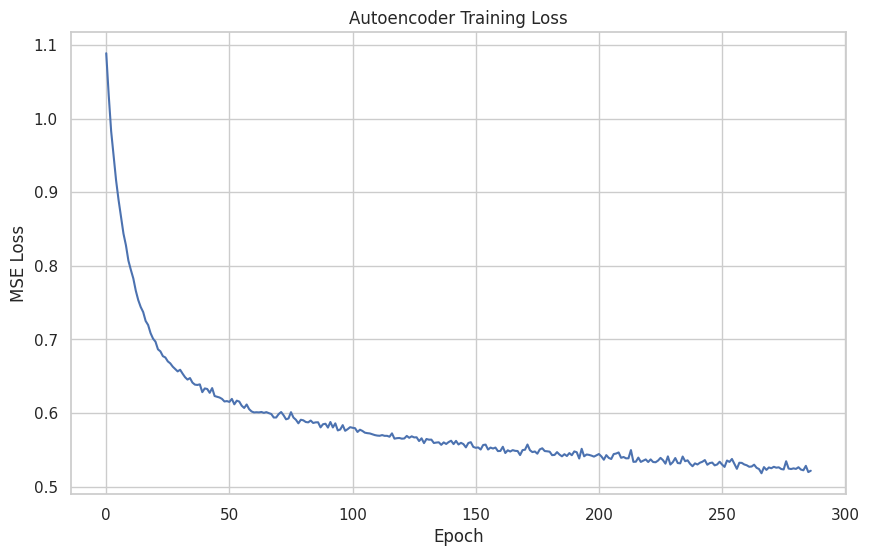

Contamination rate from cross-validation set: 0.5756


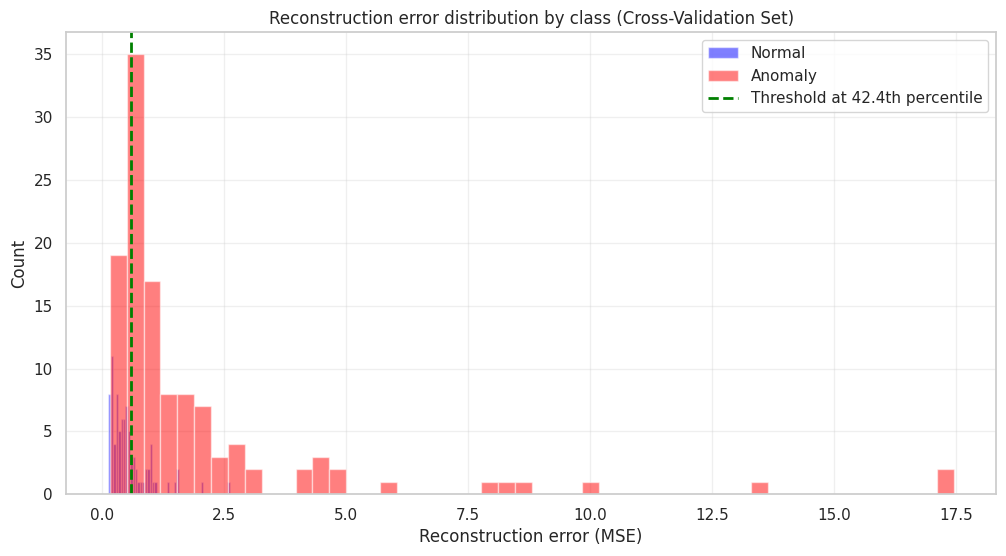

Threshold for anomaly detection: 0.596035


In [56]:
# Train the autoencoder
autoencoder_model = train_autoencoder(autoencoder_model, train_loader, num_epochs=500, patience=20)

# Function to compute reconstruction error
def compute_reconstruction_error(model, data_tensor):
    autoencoder_model.eval()
    with torch.no_grad():
        reconstructions = autoencoder_model(data_tensor)
        # Compute MSE for each sample
        mse = ((reconstructions - data_tensor) ** 2).mean(dim=1).cpu().numpy()
    return mse

# Compute reconstruction errors
train_errors = compute_reconstruction_error(autoencoder_model, X_train_tensor)
cv_errors = compute_reconstruction_error(autoencoder_model, X_cv_tensor)
test_errors = compute_reconstruction_error(autoencoder_model, X_test_tensor)

# Determine threshold for anomaly detection using cross-validation set
# We'll use the contamination rate from the cross-validation set
contamination = np.mean(y_cross_val)
print(f"Contamination rate from cross-validation set: {contamination:.4f}")

# Find the threshold that best separates normal and anomalous examples in the CV set
cv_errors_normal = cv_errors[y_cross_val == 0]
cv_errors_anomaly = cv_errors[y_cross_val == 1]

# Plot histogram of reconstruction errors by class
plt.figure(figsize=(12, 6))
plt.hist(cv_errors_normal, bins=50, alpha=0.5, label='Normal', color='blue')
plt.hist(cv_errors_anomaly, bins=50, alpha=0.5, label='Anomaly', color='red')
plt.axvline(x=np.percentile(cv_errors, 100 * (1 - contamination)),
            color='green', linestyle='dashed', linewidth=2,
            label=f'Threshold at {100 * (1 - contamination):.1f}th percentile')
plt.title('Reconstruction error distribution by class (Cross-Validation Set)')
plt.xlabel('Reconstruction error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Set threshold at the percentile corresponding to the contamination rate
threshold = np.percentile(cv_errors, 100 * (1 - contamination))
print(f"Threshold for anomaly detection: {threshold:.6f}")

# Make predictions on test set
y_pred = (test_errors > threshold).astype(int)

In [57]:
# Evaluate the autoencoder model
def evaluate_autoencoder(y_true, y_pred, reconstruction_errors, threshold):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print("\nAutoencoder performance:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 32})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Autoencoder')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, reconstruction_errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve - Autoencoder')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Evaluate autoencoder performance
ae_metrics = evaluate_autoencoder(y_test, y_pred, test_errors, threshold)

metrics_df.loc['Autoencoder'] = {
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred, zero_division=0)
}



Autoencoder performance:
Precision: 0.7188
Recall: 0.7731
F1 Score: 0.7449


## LSTM AUTOENCODER
Long Short Term Autoencoder


Using device: cpu
Epoch 1/200 - Loss: 1.002059
Epoch 2/200 - Loss: 0.994871
Epoch 3/200 - Loss: 0.985716
Epoch 4/200 - Loss: 0.982398
Epoch 5/200 - Loss: 0.983085
Epoch 6/200 - Loss: 0.981067
Epoch 7/200 - Loss: 0.976221
Epoch 8/200 - Loss: 0.977315
Epoch 9/200 - Loss: 0.976672
Epoch 10/200 - Loss: 0.974179
Epoch 11/200 - Loss: 0.969012
Epoch 12/200 - Loss: 0.965929
Epoch 13/200 - Loss: 0.962019
Epoch 14/200 - Loss: 0.957395
Epoch 15/200 - Loss: 0.960726
Epoch 16/200 - Loss: 0.955695
Epoch 17/200 - Loss: 0.953679
Epoch 18/200 - Loss: 0.945578
Epoch 19/200 - Loss: 0.943987
Epoch 20/200 - Loss: 0.946067
Epoch 21/200 - Loss: 0.942581
Epoch 22/200 - Loss: 0.943697
Epoch 23/200 - Loss: 0.941931
Epoch 24/200 - Loss: 0.938155
Epoch 25/200 - Loss: 0.930151
Epoch 26/200 - Loss: 0.930316
Epoch 27/200 - Loss: 0.931197
Epoch 28/200 - Loss: 0.920677
Epoch 29/200 - Loss: 0.917805
Epoch 30/200 - Loss: 0.924690
Epoch 31/200 - Loss: 0.925729
Epoch 32/200 - Loss: 0.912147
Epoch 33/200 - Loss: 0.906239
E

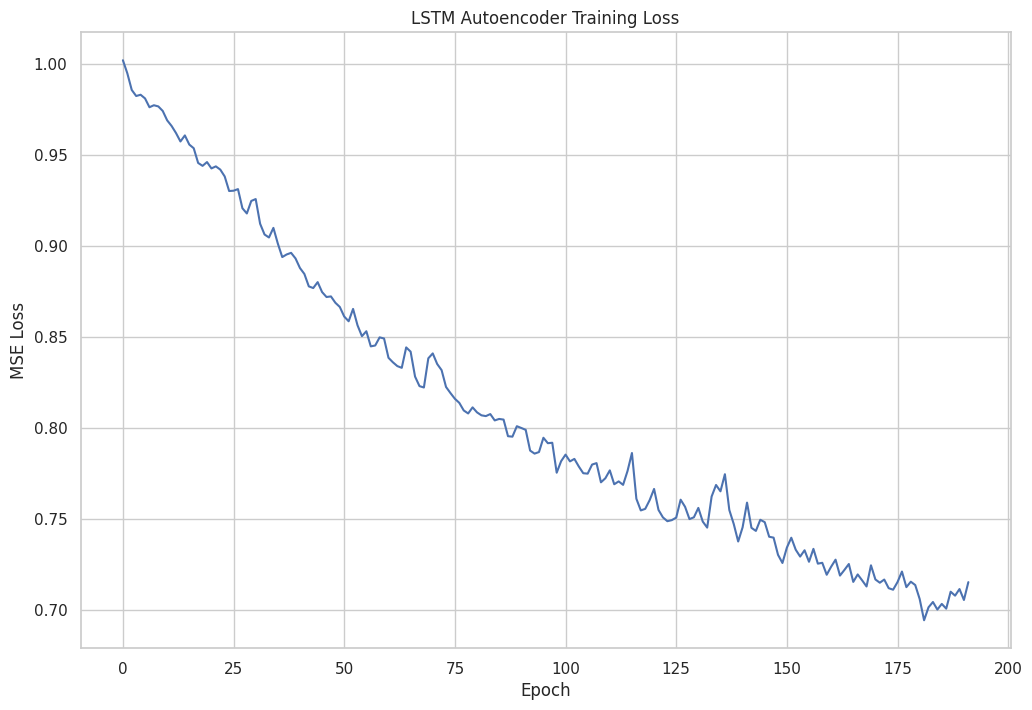

Contamination rate: 0.6344
Threshold: 1.506346

--- LSTM Autoencoder Anomaly Detection ---
Accuracy : 0.9415
Precision: 0.9219
Recall   : 0.9916
F1 Score : 0.9555


In [58]:
seed = 12
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# sliding window
def create_sliding_windows(X, window_size):
    X_windows = []
    for i in range(X.shape[0] - window_size + 1):
        X_windows.append(X[i:i+window_size])
    return np.array(X_windows)

# Dataset with sliding windows
window_size = 20  # numero di giorni nella sequenza
X_train_windows = create_sliding_windows(X_train_scaled, window_size)
X_cv_windows = create_sliding_windows(X_cv_scaled, window_size)
X_test_windows = create_sliding_windows(X_test_scaled, window_size)

X_train_tensor = torch.tensor(X_train_windows).float().to(device)
X_cv_tensor = torch.tensor(X_cv_windows).float().to(device)
X_test_tensor = torch.tensor(X_test_windows).float().to(device)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor), batch_size=32, shuffle=True)

# LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=16, num_layers=2, dropout=0.3):
        super(LSTMAutoencoder, self).__init__()
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.latent = nn.Linear(hidden_dim, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n[-1]
        z = self.latent(h_n)
        decoder_input = self.decoder_input(z).unsqueeze(1).repeat(1, seq_len, 1)
        decoded_seq, _ = self.decoder_lstm(decoder_input)
        output = self.output_layer(decoded_seq)
        return output, z

#Training with Early Stopping
def reconstruction_loss(x, x_recon):
    return torch.mean((x - x_recon) ** 2)

def train_lstm_autoencoder(model, train_loader, num_epochs=200, lr=1e-3, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    no_improve_epochs = 0
    losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            x_batch = batch[0]
            optimizer.zero_grad()
            x_recon, _ = model(x_batch)
            loss = reconstruction_loss(x_batch, x_recon)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.6f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), 'lstm_autoencoder.pth')
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load('lstm_autoencoder.pth'))

    plt.plot(losses)
    plt.title("LSTM Autoencoder Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()

    return model

model = LSTMAutoencoder(input_dim=42, hidden_dim=64, latent_dim=16).to(device)
model = train_lstm_autoencoder(model, train_loader, num_epochs=200, lr=1e-3, patience=10)

#Anomaly Detection
def compute_reconstruction_error(model, data_tensor):
    model.eval()
    with torch.no_grad():
        x_recon, _ = model(data_tensor)
        errors = ((x_recon - data_tensor) ** 2).mean(dim=(1,2)).cpu().numpy()
    return errors

cv_errors = compute_reconstruction_error(model, X_cv_tensor)
test_errors = compute_reconstruction_error(model, X_test_tensor)

# Cutting labels for alignment
y_cross_val_trimmed = y_cross_val[window_size - 1:]
y_test_trimmed = y_test[window_size - 1:]

#Threshold with contamination
contamination = np.mean(y_cross_val_trimmed)
threshold = np.percentile(cv_errors, 100 * (1 - contamination))
print(f"Contamination rate: {contamination:.4f}")
print(f"Threshold: {threshold:.6f}")

# Final predictions
y_pred = (test_errors > threshold).astype(int)

# Metrics
print("\n--- LSTM Autoencoder Anomaly Detection ---")
print(f"Accuracy : {accuracy_score(y_test_trimmed, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_trimmed, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test_trimmed, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test_trimmed, y_pred):.4f}")

metrics_df.loc['LSTM Autoencoder'] = {
    'Precision': precision_score(y_test_trimmed, y_pred, zero_division=0),
    'Recall': recall_score(y_test_trimmed, y_pred, zero_division=0),
    'F1 Score': f1_score(y_test_trimmed, y_pred, zero_division=0)
}


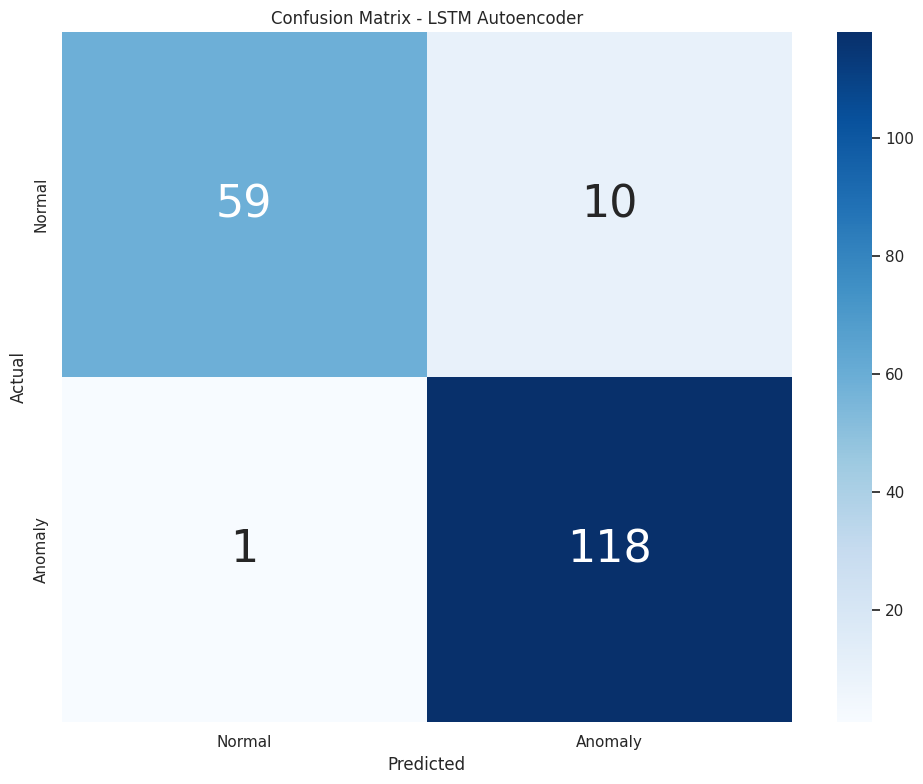

In [59]:
 # Confusion Matrix
cm = confusion_matrix(y_test_trimmed, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 32})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM Autoencoder')
plt.tight_layout()
plt.show()

## LSTM Autoencoder predictions with market anomaly direction (PCA)

In [60]:
# --- Market-based Composite Score for Conditions ---
# Extract the same feature columns as in Code A
feature_columns = [col for col in stationary_df.columns if col not in ['Y', 'Date']]
column_to_index = {col: idx for idx, col in enumerate(feature_columns)}

# Ensure your X_test_scaled is still accessible (before windowing)
# Get the last `len(y_test_trimmed)` rows to match the trimmed labels
X_test_base = X_test_scaled[-len(y_test_trimmed):]

weights = {
    'MXUS': 0.45, 'MXEU': 0.20, 'MXCN': 0.10,
    'MXJP': 0.08, 'MXIN': 0.07, 'MXBR': 0.05, 'MXRU': 0.05
}

weighted_index_scaled = np.zeros(X_test_base.shape[0])
for col, weight in weights.items():
    if col in column_to_index:
        weighted_index_scaled += X_test_base[:, column_to_index[col]] * weight

vix_scaled = X_test_base[:, column_to_index['VIX']]
composite_score = weighted_index_scaled - vix_scaled
threshold_score = np.percentile(composite_score, 50)

# Label each point based on market signal and anomaly
market_condition = []
for i, score in enumerate(composite_score):
    if y_test_trimmed[i] == 1:
        market_condition.append('Anomaly Up' if score > threshold_score else 'Anomaly Down')
    else:
        market_condition.append('Normal')

# --- PCA Projection for Visualization ---
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_base)

# --- Visual Style and Plotting ---
plt.figure(figsize=(14, 10))
size_map = {
    'True Positive': 60,
    'False Positive': 100,
    'False Negative': 100,
    'True Negative': 60
}

color_map = {
    ('True Positive', 'Anomaly Up'): 'darkgreen',
    ('True Positive', 'Anomaly Down'): 'salmon',
    ('True Positive', 'Normal'): 'lime',
    ('False Positive', 'Anomaly Up'): 'orange',
    ('False Positive', 'Anomaly Down'): 'red',
    ('False Positive', 'Normal'): 'gold',
    ('False Negative', 'Anomaly Up'): 'teal',
    ('False Negative', 'Anomaly Down'): 'purple',
    ('False Negative', 'Normal'): 'pink',
    ('True Negative', 'Anomaly Up'): 'gray',
    ('True Negative', 'Anomaly Down'): 'gray',
    ('True Negative', 'Normal'): 'gray'
}

def plot_group(mask, base_label, condition):
    count = np.sum(mask)
    if count > 0:
        label = f"{base_label} ({condition}) ({count})"
        plt.scatter(X_test_pca[mask, 0],
                    X_test_pca[mask, 1],
                    label=label,
                    c=color_map[(base_label, condition)],
                    s=size_map[base_label],
                    alpha=0.7,
                    edgecolors='k')

# Build masks and plot
y_true = y_test_trimmed
y_pred_arr = y_pred
market_condition_arr = np.array(market_condition)

for actual, predicted, label in [(0, 0, 'True Negative'),
                                  (0, 1, 'False Positive'),
                                  (1, 0, 'False Negative'),
                                  (1, 1, 'True Positive')]:
    for condition in ['Anomaly Up', 'Anomaly Down', 'Normal']:
        mask = (y_true == actual) & (y_pred_arr == predicted) & (market_condition_arr == condition)
        plot_group(mask, label, condition)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("LSTM Autoencoder Predictions with Market Anomaly Direction (PCA)")
plt.legend(fontsize=10, loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


## LSTM Autoencoder: True/False Positives/Negatives with Market Condition (3D UMAP)

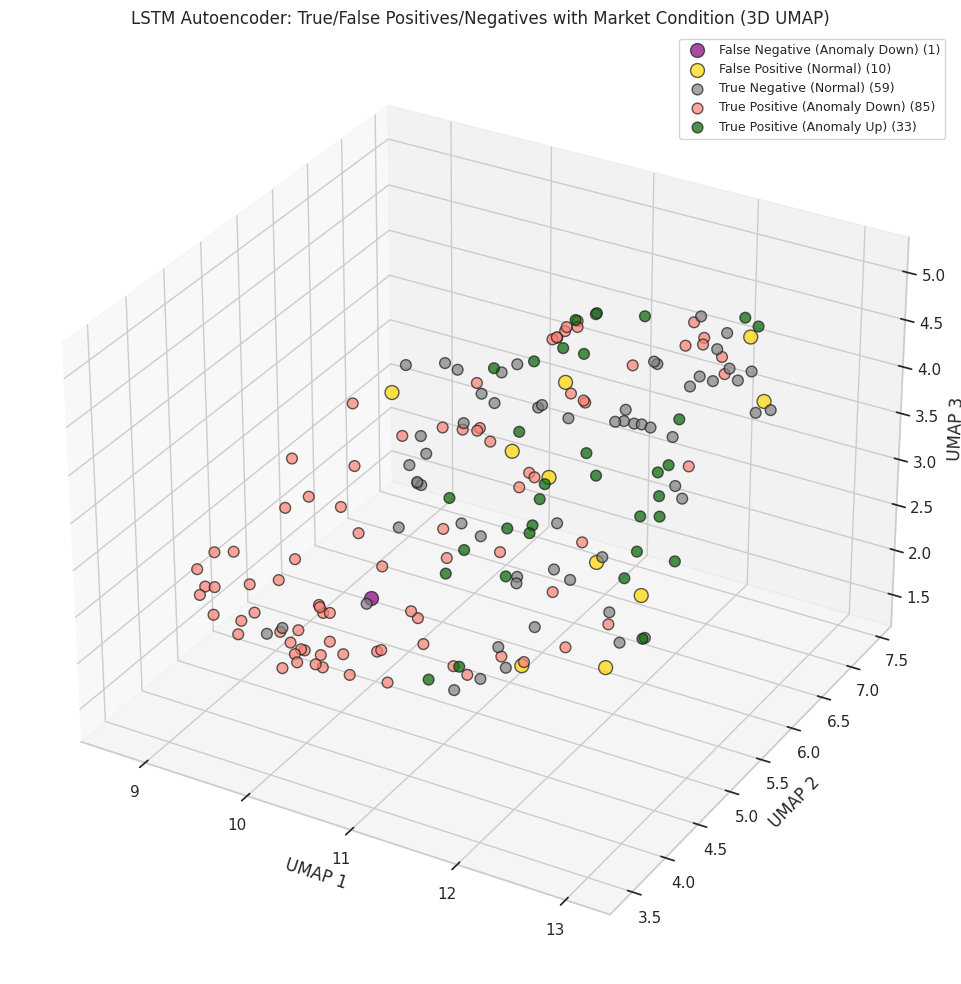

In [61]:
# --- Feature selection and composite score ---
feature_columns = [col for col in stationary_df.columns if col not in ['Y', 'Date']]
column_to_index = {col: idx for idx, col in enumerate(feature_columns)}

X_test_base = X_test_scaled[-len(y_test_trimmed):]

weights = {
    'MXUS': 0.45, 'MXEU': 0.20, 'MXCN': 0.10,
    'MXJP': 0.08, 'MXIN': 0.07, 'MXBR': 0.05, 'MXRU': 0.05
}
weighted_index_scaled = np.zeros(X_test_base.shape[0])
for col, weight in weights.items():
    if col in column_to_index:
        weighted_index_scaled += X_test_base[:, column_to_index[col]] * weight

vix_scaled = X_test_base[:, column_to_index['VIX']]
composite_score = weighted_index_scaled - vix_scaled
threshold_score = np.percentile(composite_score, 50)

market_condition = []
for i, score in enumerate(composite_score):
    if y_test_trimmed[i] == 1:
        market_condition.append('Anomaly Up' if score > threshold_score else 'Anomaly Down')
    else:
        market_condition.append('Normal')

market_condition_arr = np.array(market_condition)

# --- UMAP Projection ---
umap_reducer = umap.UMAP(n_components=3, random_state=42)
X_test_umap = umap_reducer.fit_transform(X_test_base)

# --- Define true/false positive/negative labels ---
y_true = y_test_trimmed
y_pred_arr = y_pred

# Label: e.g., 'True Positive (Anomaly Up)'
points_label = []
for i in range(len(y_true)):
    if y_true[i] == 1 and y_pred_arr[i] == 1:
        base = 'True Positive'
    elif y_true[i] == 0 and y_pred_arr[i] == 1:
        base = 'False Positive'
    elif y_true[i] == 1 and y_pred_arr[i] == 0:
        base = 'False Negative'
    else:
        base = 'True Negative'
    points_label.append((base, market_condition[i]))

points_label = np.array(points_label)

# --- Color and size maps ---
size_map = {
    'True Positive': 60,
    'False Positive': 100,
    'False Negative': 100,
    'True Negative': 60
}
color_map = {
    ('True Positive', 'Anomaly Up'): 'darkgreen',
    ('True Positive', 'Anomaly Down'): 'salmon',
    ('True Positive', 'Normal'): 'lime',
    ('False Positive', 'Anomaly Up'): 'orange',
    ('False Positive', 'Anomaly Down'): 'red',
    ('False Positive', 'Normal'): 'gold',
    ('False Negative', 'Anomaly Up'): 'teal',
    ('False Negative', 'Anomaly Down'): 'purple',
    ('False Negative', 'Normal'): 'pink',
    ('True Negative', 'Anomaly Up'): 'gray',
    ('True Negative', 'Anomaly Down'): 'gray',
    ('True Negative', 'Normal'): 'gray'
}

# --- 3D Plot ---
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(points_label, axis=0)
for base, condition in unique_labels:
    mask = (points_label[:, 0] == base) & (points_label[:, 1] == condition)
    if np.sum(mask) > 0:
        label = f"{base} ({condition}) ({np.sum(mask)})"
        ax.scatter(X_test_umap[mask, 0],
                   X_test_umap[mask, 1],
                   X_test_umap[mask, 2],
                   c=color_map[(base, condition)],
                   s=size_map[base],
                   alpha=0.7,
                   edgecolors='k',
                   label=label)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.set_title("LSTM Autoencoder: True/False Positives/Negatives with Market Condition (3D UMAP)")
ax.legend(fontsize=9, loc='best')
plt.tight_layout()
plt.show()


## Local explainability: LIME

In [62]:
# --- 1) Genera sliding windows e flattening per LIME ---
window_size = 20
# X_train_windows, X_test_windows già creati come array (n_windows, window_size, n_features)
# Li flatteniamo in (n_windows, window_size * n_features)
X_train_flat = X_train_windows.reshape(X_train_windows.shape[0], -1)
X_test_flat  = X_test_windows.reshape(X_test_windows.shape[0], -1)

# Feature names: "t{t}_{feat_name}"
base_feature_names = stationary_df.columns.tolist()  # i 42 indicatori
feature_names = [
    f"t{t}_{fname}"
    for t in range(window_size)
    for fname in base_feature_names
]

class_names = ['Normal', 'Anomaly']

# --- 2) Inizializza LIME sull’input flattenato ---
explainer = LimeTabularExplainer(
    training_data         = X_train_flat,
    feature_names         = feature_names,
    class_names           = class_names,
    mode                  = 'classification',
    discretize_continuous = True,
    random_state          = seed
)

# --- 3) Definisci la funzione di predict per LIME ---
#    usa il modello LSTM autoencoder e la soglia determinata in validazione
def predict_fn(flat_data):
    """
    flat_data: array di shape (n_instances, window_size * n_features)
    Restituisce array (n_instances, 2) con probabilità [P(Normal), P(Anomaly)].
    """
    # ricostruisci il formato (batch, window_size, n_features)
    arr = flat_data.reshape(flat_data.shape[0], window_size, -1)
    tensor = torch.tensor(arr).float().to(device)

    # calcola errori di ricostruzione
    with torch.no_grad():
        x_recon, _ = model(tensor)
        errors = ((x_recon - tensor)**2).mean(dim=(1,2)).cpu().numpy()

    # classificazione binaria con soglia
    preds = (errors > threshold).astype(int)

    # probabilità deterministiche (1.0 sulla classe scelta)
    probs = np.zeros((len(preds), 2))
    probs[np.arange(len(preds)), preds] = 1.0
    return probs

# --- 4) Spiega un’istanza di test ---
idx = 12  # scegli l’istanza
exp = explainer.explain_instance(
    data_row     = X_test_flat[idx],
    predict_fn   = predict_fn,
    num_features = 20       # mostra le top-20 feature
)

# Stampa contributi
for feat, weight in exp.as_list():
    print(f"{feat:30s} -> {weight:+.4f}")

# Verifica etichetta e ricostruzione
print(f"\nTrue label:       {y_test_trimmed[idx]}")
print(f"Ricostruzione err: {compute_reconstruction_error(model, X_test_tensor[idx:idx+1])[0]:.6f}")
print(f"Soglia:           {threshold:.6f}")

# (Opzionale) visualizza il grafico
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


t10_EMUSTRUU <= -0.46          -> +0.0278
t15_USGG3M <= -0.16            -> +0.0265
0.01 < t9_EONIA <= 0.08        -> -0.0256
0.03 < t14_MXEU <= 0.60        -> -0.0247
t18_BDIY > 0.49                -> +0.0236
t19_LMBITR > 0.58              -> -0.0219
-0.44 < t18_GTDEM2Y <= -0.03   -> +0.0211
t10_GTITL30YR <= -0.56         -> +0.0198
t1_GTJPY10YR > 0.43            -> +0.0197
-0.03 < t9_GTJPY10YR <= 0.43   -> -0.0196
-0.52 < t13_LG30TRUU <= -0.01  -> -0.0193
t17_MXEU > 0.60                -> -0.0188
t7_GBP > 0.69                  -> +0.0186
t19_LUMSTRUU > 0.52            -> +0.0184
-0.55 < t18_GBP <= 0.04        -> -0.0182
t0_LMBITR <= -0.54             -> +0.0181
t5_LF98TRUU > 0.47             -> +0.0181
-0.61 < t1_GTDEM30Y <= -0.01   -> +0.0171
t8_MXEU > 0.60                 -> +0.0158
t3_GBP <= -0.59                -> +0.0122

True label:       0.0
Ricostruzione err: 1.215160
Soglia:           1.506346


In [63]:
print("\n--- MODELS RESULTS VISUALIZATION ---\n")
# Plot the metrics for all models
print(metrics_df)


--- MODELS RESULTS VISUALIZATION ---

                                              Precision    Recall  F1 Score
MVG                                            0.617021  0.974790  0.755700
Random Forest tuned threshold                  0.755102  0.932773  0.834586
Random Forest (Tuned Threshold + Parameters)   0.829268  0.857143  0.842975
Elliptic Envelope (StandardScaler)             0.708738  0.613445  0.657658
Autoencoder                                    0.718750  0.773109  0.744939
LSTM Autoencoder                               0.921875  0.991597  0.955466


# Global explainability: zeroing out each feature and computing increase in error

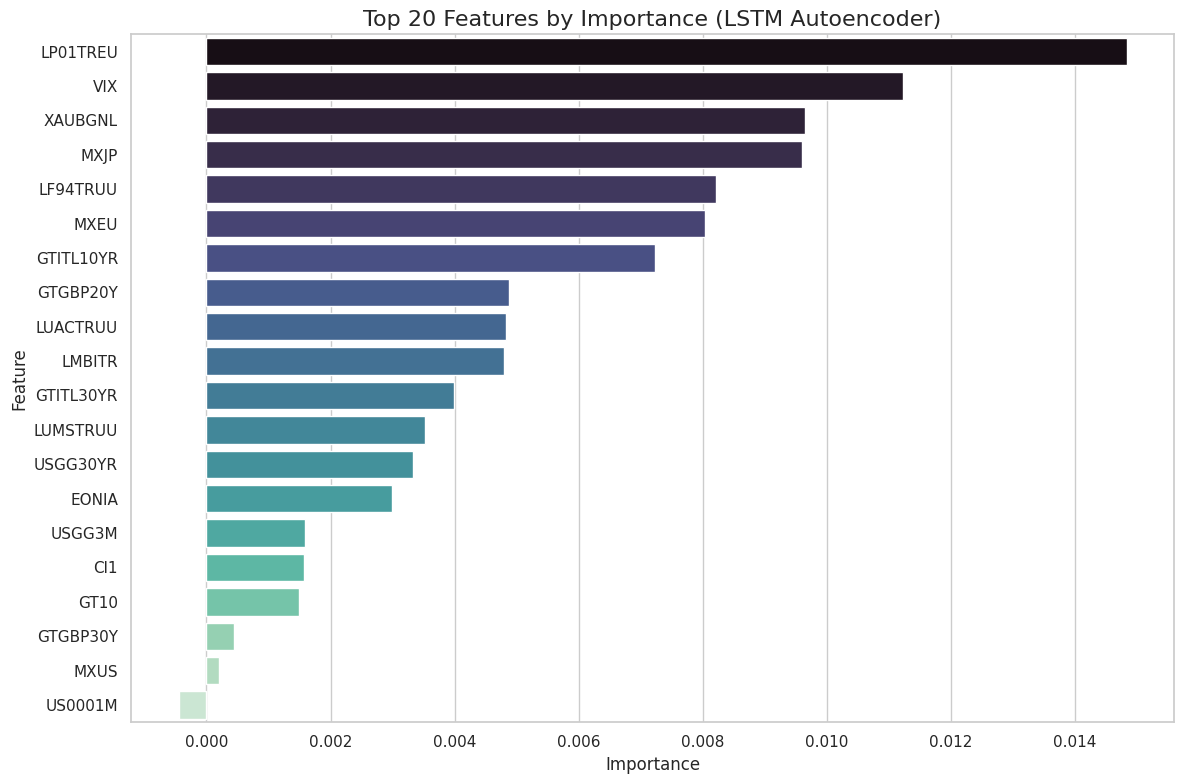

      Feature  Importance
11   LP01TREU    0.014837
41        VIX    0.011233
21    XAUBGNL    0.009655
18       MXJP    0.009600
7    LF94TRUU    0.008216
16       MXEU    0.008033
30  GTITL10YR    0.007234
27   GTGBP20Y    0.004877
12   LUACTRUU    0.004831
10     LMBITR    0.004801


In [64]:
def analyze_feature_importance_lstm(model, X_tensor, feature_names):
    """
    Analyze feature importance by measuring impact of each feature on reconstruction error (LSTM Autoencoder)
    """
    model.eval()
    n_features = X_tensor.shape[2]
    importance_scores = []

    with torch.no_grad():
        original_recon, _ = model(X_tensor)
        original_error = ((original_recon - X_tensor) ** 2).mean(dim=(1, 2)).cpu().numpy()

    for i in range(n_features):
        perturbed_input = X_tensor.clone()
        perturbed_input[:, :, i] = 0.0  # Zero out feature i across all time steps

        with torch.no_grad():
            perturbed_recon, _ = model(perturbed_input)
            perturbed_error = ((perturbed_recon - X_tensor) ** 2).mean(dim=(1, 2)).cpu().numpy()

        # Importance = mean increase in reconstruction error
        importance = np.mean(perturbed_error - original_error)
        importance_scores.append(importance)

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='mako')
    plt.title('Top 20 Features by Importance (LSTM Autoencoder)', fontsize=16)
    plt.tight_layout()
    plt.show()

    return importance_df

feature_names = stationary_df.columns
importance_df = analyze_feature_importance_lstm(model, X_test_tensor, feature_names)
print(importance_df.head(10))